## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn.metrics import r2_score
import pickle

In [61]:
import sys
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/fit')
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/extract')
sys.path.insert(1, './params')
from cper_bm_params_eval_ecosite_transect import *

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
import copy
from skorch import NeuralNetRegressor
import skorch
from dnn_setup import ResNetRegressor, ResidualBlock

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define I/O

In [68]:
from importlib import reload
reload(sys.modules["cper_bm_params_eval_ecosite_transect"])
from cper_bm_params_eval_ecosite_transect import *

In [69]:
save_results = True
outDIR = './results'

## Load and pre-process data

In [70]:
with open(os.path.join(inDIR, 'ml_train_' + nickname + '_cv_' + kfold_group + '_tuneby_' + tuneby_group + '_results.pk'), 'rb') as f:
    mod_dict = pickle.load(f)
df = pd.read_csv(inPATH)
if 'transect' in inPATH:
    df['Plot'] = df[id_col].transform(lambda x: '_'.join(x.split('_')[:-1]))
elif 'plot' in inPATH:
    df['Plot'] = df[id_col]

In [71]:
if 'Plot' not in id_cols:
    id_cols = id_cols + ['Plot']
print(id_cols)

['kfold', 'Id', 'Plot', 'Pasture', 'Date_mean', 'Year', 'Season', 'Observed', 'spatial']


In [72]:
keep_cols = var_names + id_cols + [logo_group, y_col, date_col, past_col, id_col] + group_cols + list(mod_dict.keys())

In [73]:
drop_cols = [x for x in df.columns if x not in keep_cols]

In [74]:
drop_cols

['Date', 'Low', 'High', 'geometry']

In [75]:
def r_corrcoef(y_obs, y_pred):
    corr_matrix = np.corrcoef(y_obs, y_pred)
    corr = corr_matrix[0,1]
    r = corr
    return r

In [76]:
df_bm_pred = pd.melt(df.drop(columns=drop_cols + var_names).rename(columns={y_col: 'Observed'}), 
                 id_vars=id_cols + [logo_group], 
                 value_name='Predicted',
                 var_name='Source')

In [77]:
[x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]

['kfold',
 'Id',
 'Plot',
 'Pasture',
 'Date_mean',
 'Year',
 'Season',
 'Observed',
 'spatial',
 'ecosite']

In [78]:
df_ens_lin = df_bm_pred[df_bm_pred['Source'].isin(
    ['LASSO', 'PLS', 'PCR'])].drop(columns=['Source']).groupby(
    [x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]).mean().reset_index()
df_ens_lin['Source'] = 'ENS_LIN'

df_ens_ml = df_bm_pred[df_bm_pred['Source'].isin(
    ['SVR', 'RF', 'GBR'])].drop(columns=['Source']).groupby(
    [x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]).mean().reset_index()
df_ens_ml['Source'] = 'ENS_ML'

df_ens_both = df_bm_pred[df_bm_pred['Source'].isin(
    ['LASSO', 'PLS', 'PCR', 'SVR', 'RF', 'GBR'])].drop(columns=['Source']).groupby(
    [x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]).mean().reset_index()
df_ens_both['Source'] = 'ENS_ALL'

In [79]:
df_bm_pred = pd.concat([df_bm_pred, df_ens_lin, df_ens_ml, df_ens_both])

In [80]:
for k in df_bm_pred['Source'].unique():
    if k in mod_dict.keys():
        if mod_dict[k]['xfrm_y'] is not None:
            df_bm_pred.loc[df_bm_pred['Source'] == k, 
            'Observed_xfrm'] = mod_dict[k]['xfrm_y'](df_bm_pred.loc[df_bm_pred['Source'] == k, 'Observed'])
            df_bm_pred.loc[df_bm_pred['Source'] == k, 
            'Predicted_xfrm'] = mod_dict[k]['xfrm_y'](df_bm_pred.loc[df_bm_pred['Source'] == k, 'Predicted'])
    else:
        df_bm_pred.loc[df_bm_pred['Source'] == k, 
        'Observed_xfrm'] = mod_dict['PLS']['xfrm_y'](df_bm_pred.loc[df_bm_pred['Source'] == k, 'Observed'])
        df_bm_pred.loc[df_bm_pred['Source'] == k, 
        'Predicted_xfrm'] = mod_dict['PLS']['xfrm_y'](df_bm_pred.loc[df_bm_pred['Source'] == k, 'Predicted'])

In [81]:
mods = ['CPER_2022', 'OLS_2022', 'OLS', 
        'LASSO', 'PLS', 'PCR', 
        'SVR', 'RF', 'GBR', 'DNN',
        'ENS_LIN', 'ENS_ML', 'ENS_ALL']

In [82]:
df_bm_pred['Source'] = pd.Categorical(df_bm_pred['Source'], 
                                      categories=mods)

In [83]:
df_bm_pred['Source'] = df_bm_pred['Source'].cat.remove_unused_categories()

In [84]:
df_bm_pred[df_bm_pred['Source'].isnull()]

Empty DataFrame
Columns: [kfold, Id, Plot, Pasture, Date_mean, Year, Season, Observed, spatial, ecosite, Source, Predicted, Observed_xfrm, Predicted_xfrm]
Index: []

In [85]:
df_bm_pred[df_bm_pred['Observed_xfrm'].isnull()]

Empty DataFrame
Columns: [kfold, Id, Plot, Pasture, Date_mean, Year, Season, Observed, spatial, ecosite, Source, Predicted, Observed_xfrm, Predicted_xfrm]
Index: []

In [86]:
df_bm_pred

kfold        Id    Plot Pasture   Date_mean  Year   Season     Observed  \
0     Loamy  10S_P1_1  10S_P1     10S  2014-06-12  2014     June  1280.282775   
1     Sandy  31E_P4_1  31E_P4     31E  2014-06-12  2014     June  1557.012039   
2     Loamy  31E_P3_4  31E_P3     31E  2014-06-12  2014     June   746.019804   
3     Loamy  31E_P3_3  31E_P3     31E  2014-06-12  2014     June   717.349423   
4     Loamy  31E_P3_2  31E_P3     31E  2014-06-12  2014     June  1288.316568   
...     ...       ...     ...     ...         ...   ...      ...          ...   
9195  Sandy   8E_P4_4   8E_P4      8E  2021-09-27  2021  October   520.778723   
9196  Sandy   8E_P4_4   8E_P4      8E  2022-06-02  2022     June   440.295831   
9197  Sandy   8E_P4_4   8E_P4      8E  2022-10-05  2022  October   432.142742   
9198  Sandy   8E_P4_4   8E_P4      8E  2023-06-07  2023     June   501.256681   
9199  Sandy   8E_P4_4   8E_P4      8E  2023-09-25  2023  October  1340.695778   

      spatial ecosite     Source    Predicted  Observed_xfrm  Predicted_xfrm  
0           5   Loamy  CPER_2022  1614.799447       7.155617        7.387585  
1           3   Sandy  CPER_2022   953.400493       7.351166        6.861083  
2           3   Loamy  CPER_2022   812.821793       6.616092        6.701741  
3           3   Loamy  CPER_2022   688.037089       6.576956        6.535295  
4           3   Loamy  CPER_2022   693.749549       7.161868        6.543551  
...       ...     ...        ...          ...            ...             ...  
9195        1   Sandy    ENS_ALL   595.225845      22.820577       24.397251  
9196        1   Sandy    ENS_ALL   477.766726      20.983227       21.857876  
9197        1   Sandy    ENS_ALL   781.945702      20.788043       27.963292  
9198        1   Sandy    ENS_ALL  1038.461732      22.388762       32.225172  
9199        1   Sandy    ENS_ALL  1566.101088      36.615513       39.573995  

[119600 rows x 14 columns]

## Check disaggregated prediction

In [87]:
#df_bm_pred = df_bm_pred.groupby([mod_col, logo_group,  id_col, date_col] + group_cols).mean().reset_index().dropna()

In [88]:
mae_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    lambda x: np.mean(abs(x['Predicted_xfrm'] - x['Observed_xfrm'])), include_groups=False).round(2)
bias_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    lambda x: np.mean(x['Predicted_xfrm'] - x['Observed_xfrm']), include_groups=False).round(2)
mae_bt_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    lambda x: np.mean(abs(x['Predicted'] - x['Observed'])), include_groups=False).round(2)
r2_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    (lambda x: r2_score(x['Observed_xfrm'], x['Predicted_xfrm'])), include_groups=False).round(2)
r2_corr_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
        lambda x: r_corrcoef(x['Observed_xfrm'], x['Predicted_xfrm']), include_groups=False).round(2)

In [89]:
df_smry_obs = pd.DataFrame({
    'MAE': mae_obs.round(2),
    'Bias': bias_obs.round(2),
    'R^2': r2_obs.round(2),
    'r': r2_corr_obs.round(2),
    'MAE_bt': mae_bt_obs.round(2),
    'MAE_bt_pct': (mae_bt_obs / df_bm_pred[[mod_col, 'Observed']].groupby([mod_col], observed=True).mean()['Observed']).round(2),
})
display(df_smry_obs)

MAE  Bias   R^2     r  MAE_bt  MAE_bt_pct
Source                                               
CPER_2022  0.35  0.03  0.49  0.70  288.46        0.33
OLS_2022   4.39  0.36  0.56  0.75  266.09        0.31
OLS        4.57  0.48  0.53  0.74  277.90        0.32
LASSO      4.43  0.68  0.55  0.75  268.86        0.31
PLS        4.44  0.55  0.56  0.75  268.82        0.31
PCR        4.44  0.52  0.56  0.75  268.55        0.31
SVR        4.38  0.12  0.56  0.75  266.57        0.31
RF         4.27  0.53  0.58  0.77  260.05        0.30
GBR        4.23  0.05  0.58  0.76  257.15        0.30
DNN        4.65 -0.13  0.48  0.69  282.14        0.33
ENS_LIN    4.41  0.59  0.56  0.75  267.32        0.31
ENS_ML     4.21  0.25  0.59  0.77  256.50        0.30
ENS_ALL    4.28  0.43  0.58  0.76  260.17        0.30

In [90]:
max_lim = max(df_bm_pred[['Observed', 'Predicted']].max())*1.1
max_lim_xfrm = max(df_bm_pred[['Observed_xfrm', 'Predicted_xfrm']].max())*1.1

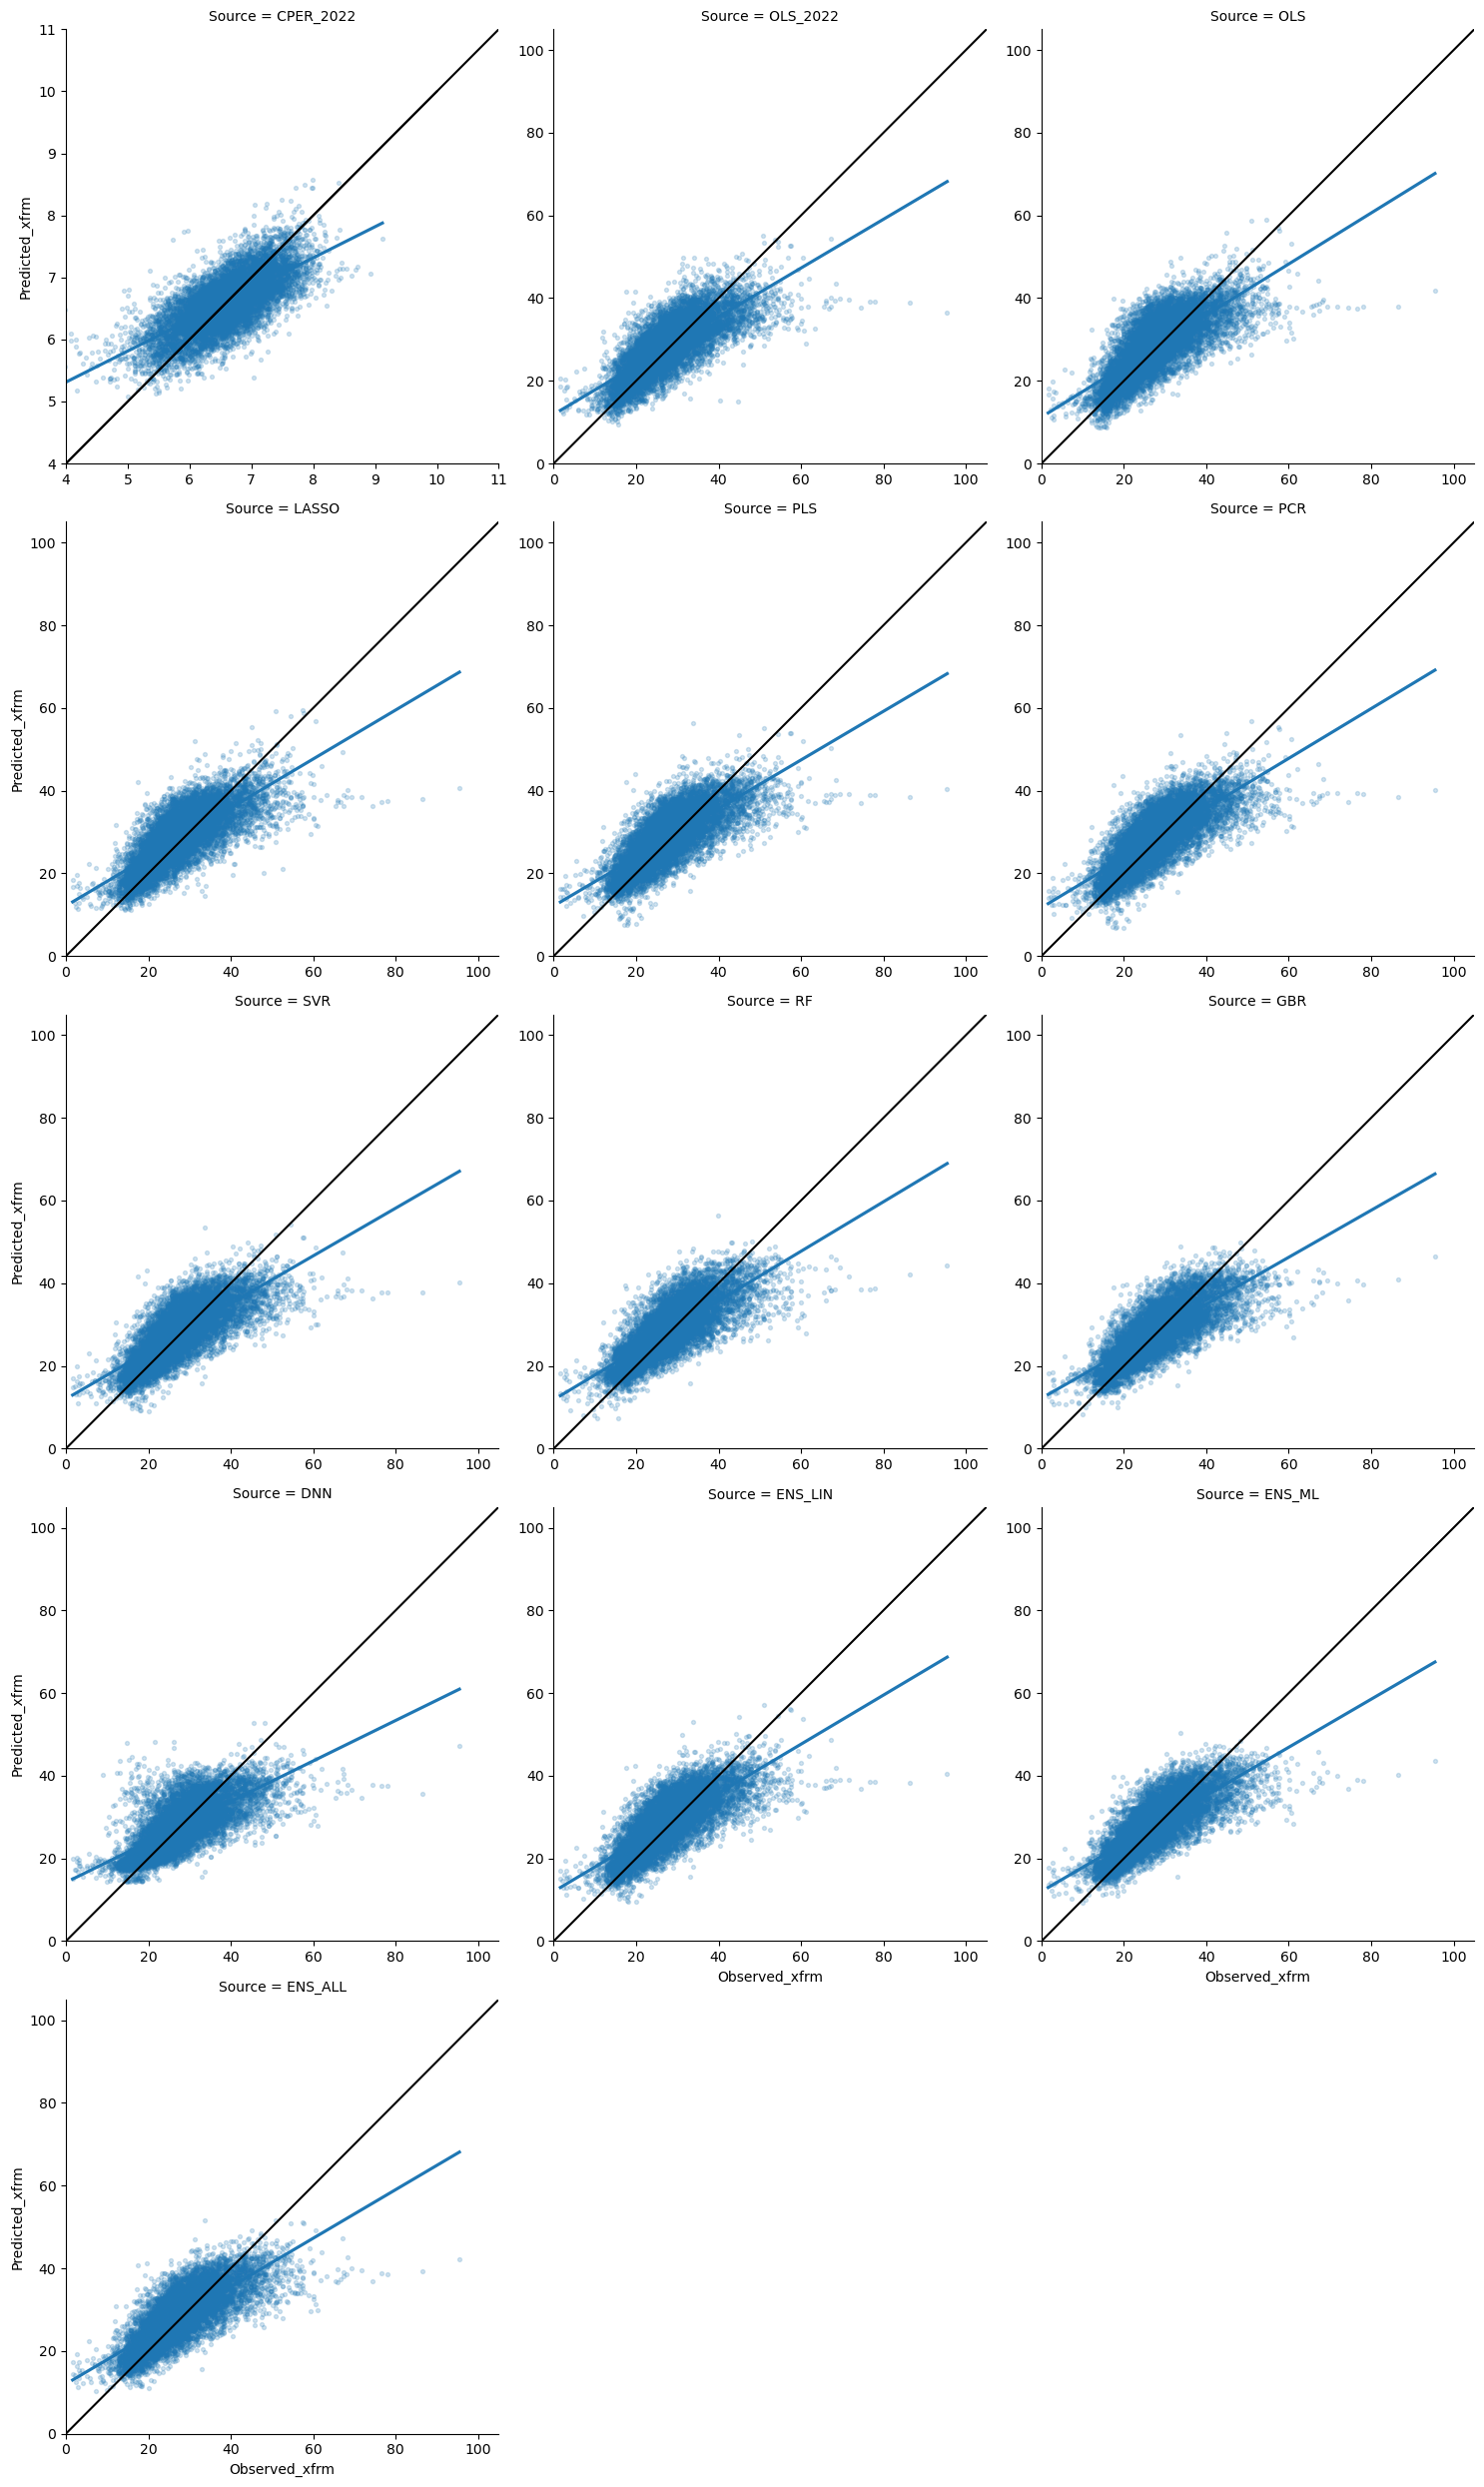

In [91]:
p_obs = sns.lmplot(df_bm_pred,
               x='Observed_xfrm', y='Predicted_xfrm', col=mod_col, col_wrap=3, ci=None,
                   facet_kws=dict(sharey=False, sharex=False,),
                    scatter_kws={'s': 8, 'alpha': 0.2, 'edgecolor': None})
for ax in p_obs.axes:
    ax.set_ylim((0, max_lim_xfrm))
    ax.set_xlim((0, max_lim_xfrm))
    ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')
p_obs.axes[0].set_ylim((4, 11))
p_obs.axes[0].set_xlim((4, 11))
p_obs.axes[0].plot(np.arange(4, 11), np.arange(4, 11), c='black')

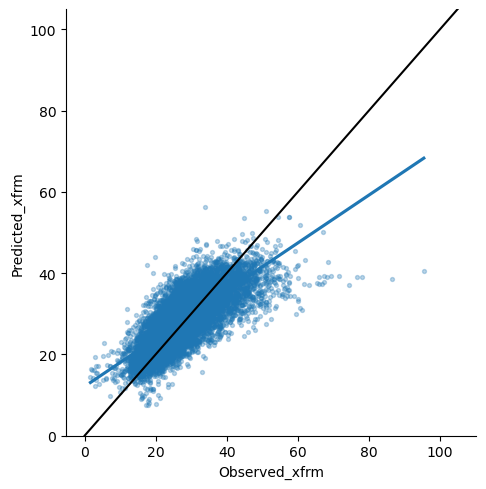

In [92]:
p_obs_best = sns.lmplot(df_bm_pred[df_bm_pred[mod_col] == 'PLS'],
               x='Observed_xfrm', y='Predicted_xfrm', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.3, 'edgecolor': None})
for ax in p_obs_best.axes.flatten():
        ax.set_ylim((0, max_lim_xfrm))
        ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')

## Get aggregated predictions

### Transect

MAE  MAE_std  Bias  Bias_std   R^2  R^2_std     r  r_std  MAE_bt  \
Source                                                                         
CPER_2022  0.35     0.03 -0.02      0.11  0.40     0.05  0.66   0.02  333.80   
OLS_2022   4.68     0.59 -0.77      2.29  0.49     0.03  0.75   0.02  304.10   
OLS        4.69     0.28 -0.58      2.26  0.47     0.04  0.75   0.02  304.11   
LASSO      4.56     0.28 -0.40      2.36  0.49     0.02  0.75   0.02  295.33   
PLS        4.59     0.29 -0.58      2.40  0.49     0.03  0.75   0.01  297.56   
PCR        4.58     0.29 -0.59      2.35  0.50     0.03  0.76   0.01  296.92   
SVR        4.64     0.53 -1.11      2.54  0.48     0.03  0.76   0.01  302.67   
RF         4.50     0.47 -0.58      2.32  0.51     0.03  0.76   0.02  293.80   
GBR        4.58     0.70 -1.17      2.48  0.49     0.06  0.75   0.02  299.00   
DNN        4.97     0.67 -1.58      2.95  0.39     0.07  0.71   0.04  323.80   
ENS_LIN    4.55     0.29 -0.51      2.37  0.50     0.02  0.76   0.01  295.00   
ENS_ML     4.48     0.54 -0.94      2.45  0.51     0.04  0.77   0.01  293.01   
ENS_ALL    4.48     0.40 -0.72      2.40  0.51     0.02  0.77   0.01  291.74   

           MAE_bt_std  MAE_bt_pct  MAE_bt_pct_std  Bias_bt  Bias_bt_std  
Source                                                                   
CPER_2022       91.94        0.33            0.03   -97.20        98.15  
OLS_2022        76.64        0.30            0.02   -86.76       156.88  
OLS             53.19        0.31            0.04   -66.98       154.77  
LASSO           53.67        0.30            0.04   -59.52       154.12  
PLS             57.92        0.30            0.03   -73.71       160.00  
PCR             57.18        0.30            0.03   -71.95       157.07  
SVR             72.80        0.30            0.02  -108.76       173.59  
RF              68.25        0.29            0.02   -72.77       151.86  
GBR             84.75        0.29            0.01  -114.13       167.26  
DNN             85.21        0.32            0.01  -143.45       197.91  
ENS_LIN         55.89        0.30            0.03   -68.40       156.83  
ENS_ML          73.72        0.29            0.02   -98.55       163.97  
ENS_ALL         63.63        0.29            0.03   -83.47       159.83

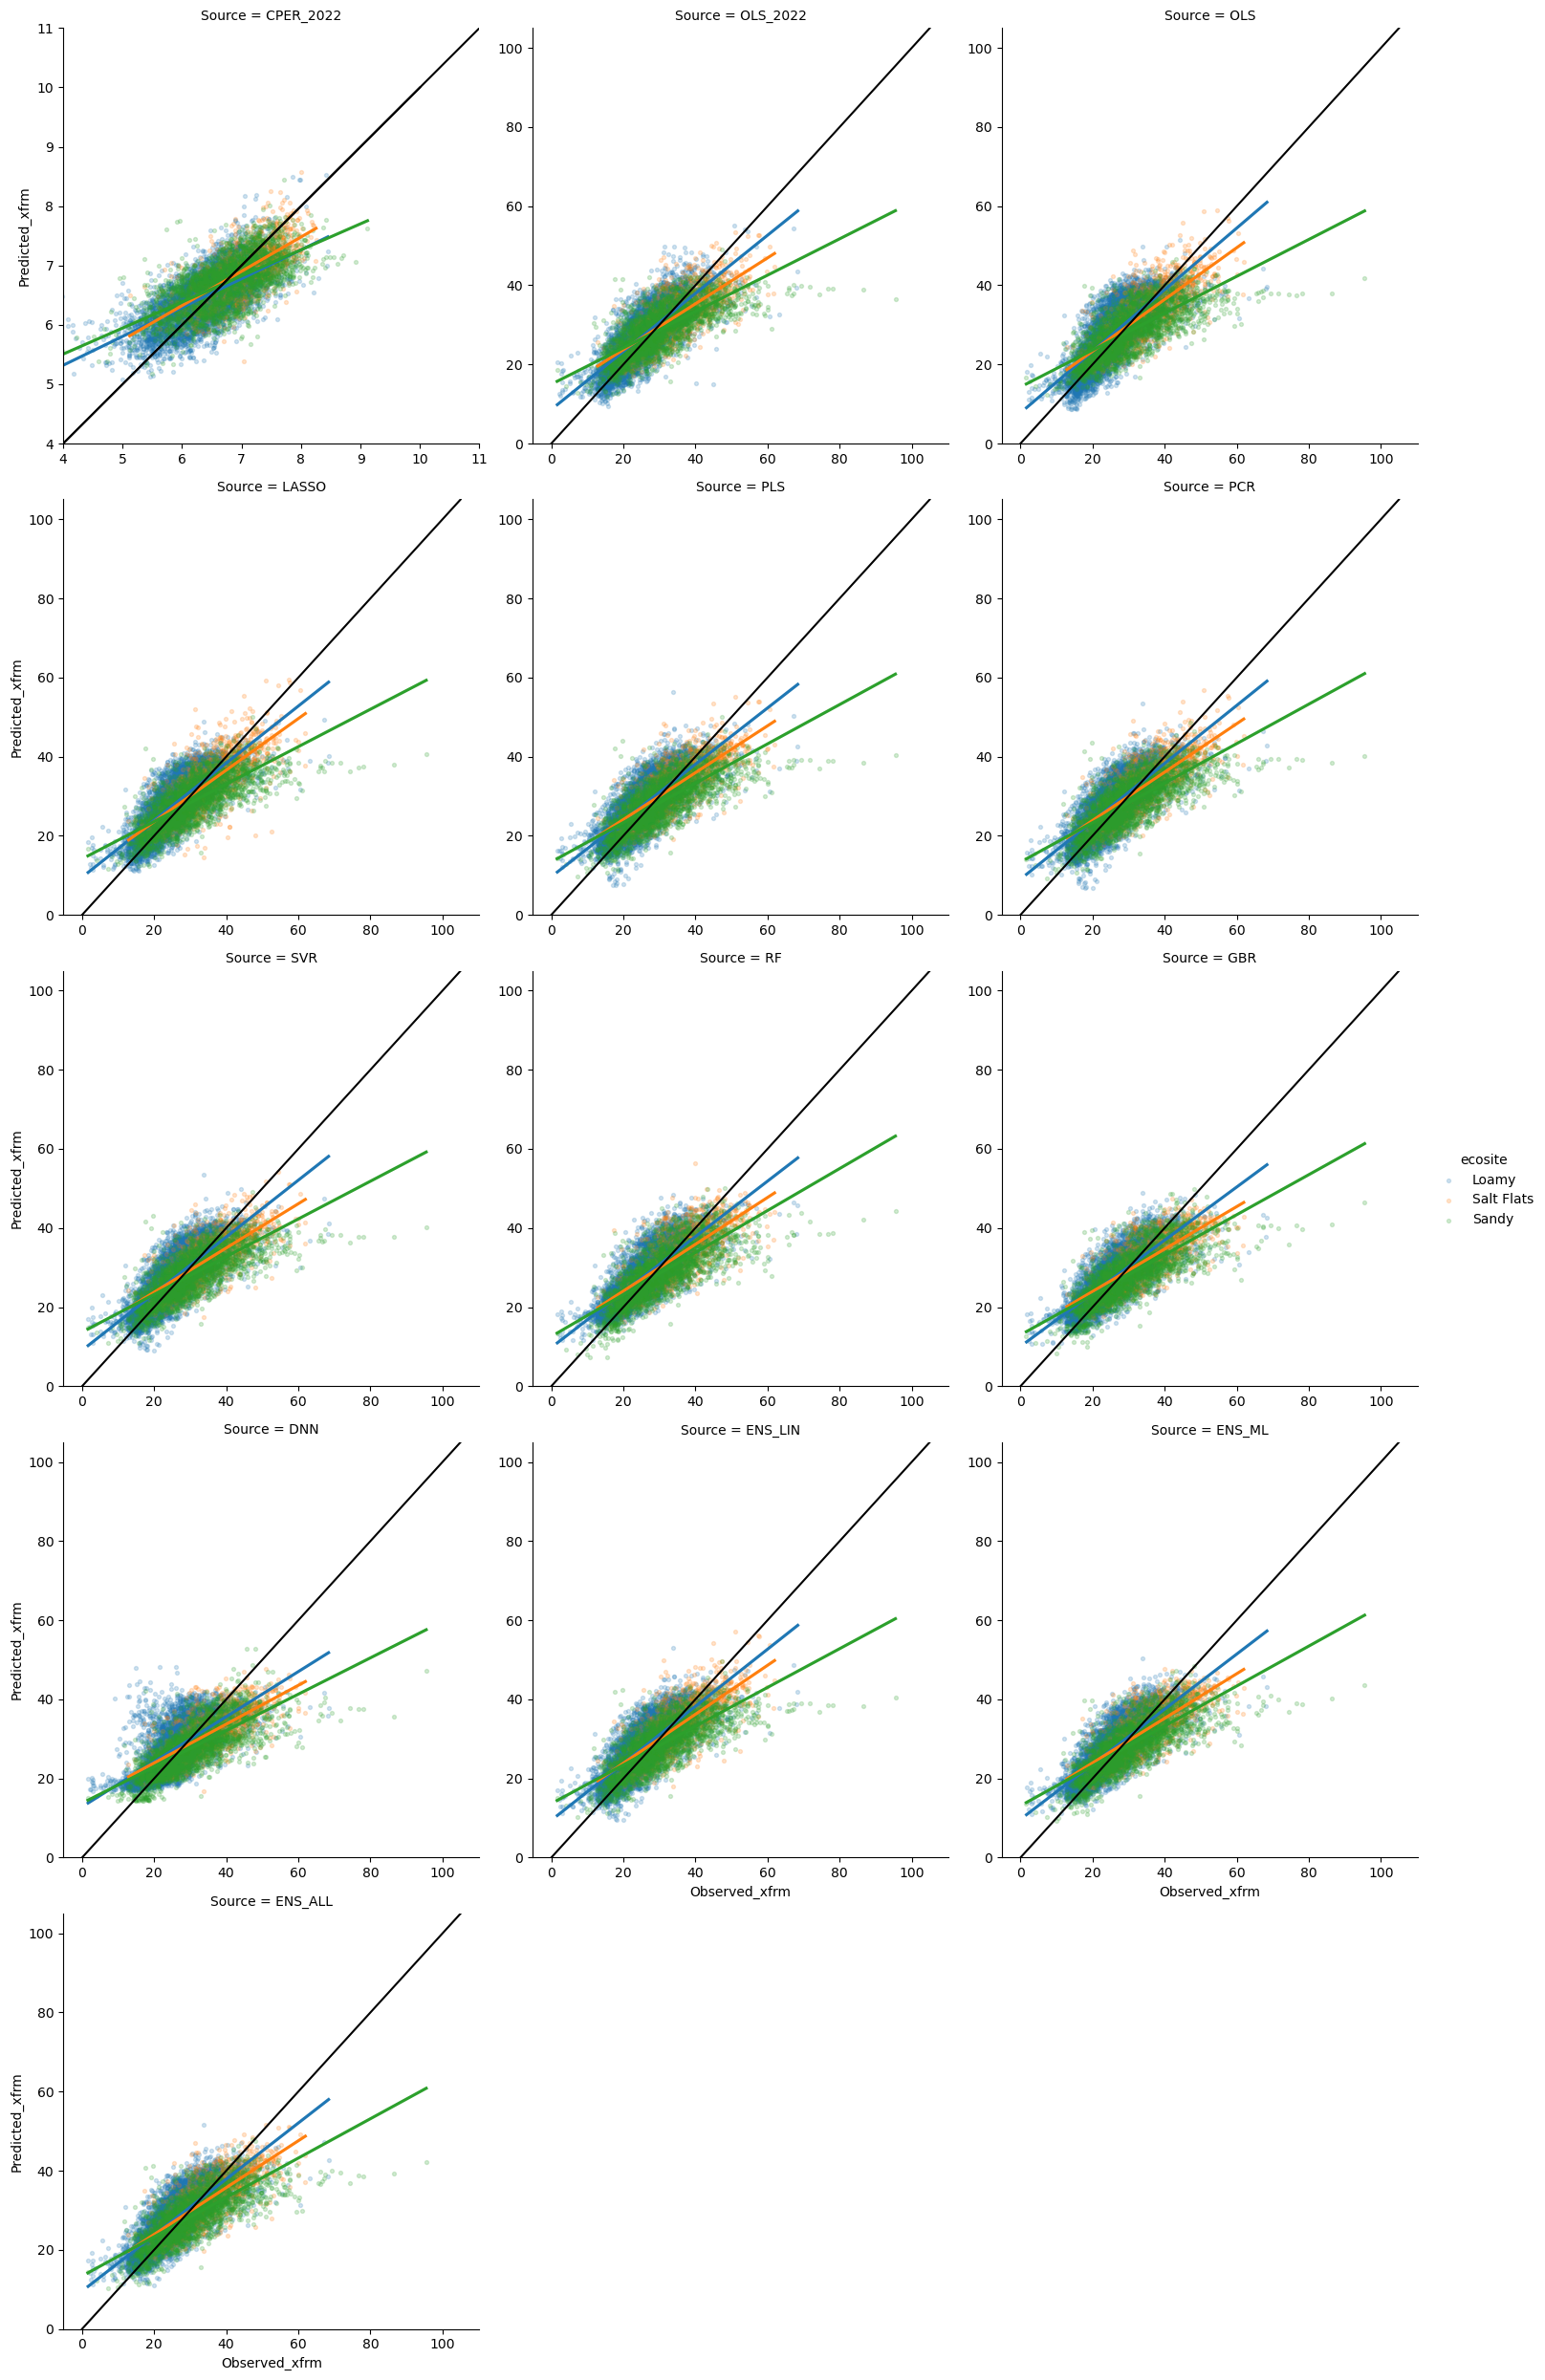

In [93]:
if 'transect' in inPATH:
    mae_transect = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
        lambda z: z.groupby([id_col, date_col]).apply(
            lambda x: abs(np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm'])), 
            include_groups=False).mean(), include_groups=False).round(2)
    bias_transect = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
        lambda z: z.groupby([id_col, date_col]).apply(
            lambda x: np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm']),
            include_groups=False).mean(), include_groups=False).round(2)
    mae_bt_transect = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
        lambda z: z.groupby([id_col, date_col]).apply(
            lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])), 
            include_groups=False).mean(), include_groups=False).round(2)
    bias_bt_transect = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
        lambda z: z.groupby([id_col, date_col]).apply(
            lambda x: np.mean(x['Predicted']) - np.mean(x['Observed']), 
            include_groups=False).mean(), include_groups=False).round(2)
    r2_transect = df_bm_pred.groupby([mod_col, logo_group, id_col, date_col], 
                                 observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby(
        [mod_col, logo_group], observed=True).apply(
        lambda x: r2_score(x['Observed_xfrm'], x['Predicted_xfrm']), 
        include_groups=False).round(2)
    r2_corr_transect = df_bm_pred.groupby([mod_col, logo_group, id_col, past_col, date_col], 
                                 observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby(
        [mod_col, logo_group], observed=True).apply(
            lambda x: r_corrcoef(x['Observed_xfrm'], x['Predicted_xfrm']),
        include_groups=False).round(2)

    df_smry_transect = pd.DataFrame({
        'MAE': mae_transect.unstack(level=0).mean().round(2),
        'MAE_std': mae_transect.unstack(level=0).std().round(2),
        'Bias': bias_transect.unstack(level=0).mean().round(2),
        'Bias_std': bias_transect.unstack(level=0).std().round(2),
        'R^2': r2_transect.unstack(level=0).mean().round(2),
        'R^2_std': r2_transect.unstack(level=0).std().round(2),
        'r': r2_corr_transect.unstack(level=0).mean().round(2),
        'r_std': r2_corr_transect.unstack(level=0).std().round(2),
        'MAE_bt': mae_bt_transect.unstack(level=0).mean().round(2),
        'MAE_bt_std': mae_bt_transect.unstack(level=0).std().round(2),
        'MAE_bt_pct': (mae_bt_transect / df_bm_pred.groupby([mod_col, logo_group], 
                                                        observed=True)['Observed'].mean()).unstack(level=0).mean().round(2),
        'MAE_bt_pct_std': (mae_bt_transect / df_bm_pred.groupby([mod_col, logo_group], 
                                                        observed=True)['Observed'].mean()).unstack(level=0).std().round(2),
        'Bias_bt': bias_bt_transect.unstack(level=0).mean().round(2),
        'Bias_bt_std': bias_bt_transect.unstack(level=0).std().round(2),
    })
    display(df_smry_transect)
    if save_results:
        df_smry_transect.to_csv(os.path.join(outDIR,
                                             'tables/ml_models', 
                                             re.sub('tmp.csv', 'results_transect.csv', os.path.basename(inPATH))))
    
    df_smry_transect_by_yr = pd.DataFrame({
        'MAE': mae_transect.round(2),
        'Bias': bias_transect.round(2),
        'MAE_bt': mae_bt_transect.round(2),
        'MAE_pct': (mae_bt_transect / df_bm_pred.groupby([mod_col, logo_group], observed=True)['Observed'].mean()).round(2),
        'R^2': r2_transect.round(2),
        'r': r2_corr_transect.round(2)
    })
    #display(df_smry_transect_by_yr)
    if save_results:
        df_smry_transect_by_yr.to_csv(os.path.join(outDIR,
                                                   'tables/ml_models', 
                                                   re.sub('tmp.csv', 'results_transect_yrly.csv', os.path.basename(inPATH))))

    p_transect = sns.lmplot(df_bm_pred.groupby([mod_col, logo_group, id_col, date_col], 
                                           observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index(),
                   x='Observed_xfrm', y='Predicted_xfrm', col=mod_col, col_wrap=3,
                        facet_kws=dict(sharey=False, sharex=False,),
                        hue=logo_group, ci=None,
                        scatter_kws={'s': 8, 'alpha': 0.2, 'edgecolor': None})
    for ax in p_transect.axes:
        ax.set_ylim((0, max_lim_xfrm))
        ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')
    p_transect.axes[0].set_ylim((4, 11))
    p_transect.axes[0].set_xlim((4, 11))
    p_transect.axes[0].plot(np.arange(4, 11), np.arange(4, 11), c='black')
    if save_results:
        plt.savefig(os.path.join(outDIR, 
                                 'figures/ml_models',
                                 re.sub('tmp.csv', 'results_transect.png', os.path.basename(inPATH))), dpi=100)

### Plot

In [94]:
mae_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby(['Plot', date_col]).apply(
        lambda x: abs(np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm'])), 
        include_groups=False).mean(), include_groups=False).round(2)
bias_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby(['Plot', date_col]).apply(
        lambda x: np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm']),
        include_groups=False).mean(), include_groups=False).round(2)
mae_bt_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby(['Plot', date_col]).apply(
        lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])), 
        include_groups=False).mean(), include_groups=False).round(2)
bias_bt_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby(['Plot', date_col]).apply(
        lambda x: np.mean(x['Predicted']) - np.mean(x['Observed']), 
        include_groups=False).mean(), include_groups=False).round(2)
r2_plot = df_bm_pred.groupby([mod_col, logo_group, 'Plot', date_col], 
                             observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby(
    [mod_col, logo_group], observed=True).apply(
    lambda x: r2_score(x['Observed_xfrm'], x['Predicted_xfrm']), 
    include_groups=False).round(2)
r2_corr_plot = df_bm_pred.groupby([mod_col, logo_group, 'Plot', past_col, date_col], 
                             observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby(
    [mod_col, logo_group], observed=True).apply(
        lambda x: r_corrcoef(x['Observed_xfrm'], x['Predicted_xfrm']),
    include_groups=False).round(2)

In [95]:
df_smry_plot = pd.DataFrame({
    'MAE': mae_plot.unstack(level=0).mean().round(2),
    'MAE_std': mae_plot.unstack(level=0).std().round(2),
    'Bias': bias_plot.unstack(level=0).mean().round(2),
    'Bias_std': bias_plot.unstack(level=0).std().round(2),
    'R^2': r2_plot.unstack(level=0).mean().round(2),
    'R^2_std': r2_plot.unstack(level=0).std().round(2),
    'r': r2_corr_plot.unstack(level=0).mean().round(2),
    'r_std': r2_corr_plot.unstack(level=0).std().round(2),
    'MAE_bt': mae_bt_plot.unstack(level=0).mean().round(2),
    'MAE_bt_std': mae_bt_plot.unstack(level=0).std().round(2),
    'MAE_bt_pct': (mae_bt_plot / df_bm_pred.groupby([mod_col, logo_group], 
                                                    observed=True)['Observed'].mean()).unstack(level=0).mean().round(2),
    'MAE_bt_pct_std': (mae_bt_plot / df_bm_pred.groupby([mod_col, logo_group], 
                                                    observed=True)['Observed'].mean()).unstack(level=0).std().round(2),
    'Bias_bt': bias_bt_plot.unstack(level=0).mean().round(2),
    'Bias_bt_std': bias_bt_plot.unstack(level=0).std().round(2),
})
display(df_smry_plot)
if save_results:
    df_smry_plot.to_csv(os.path.join(outDIR,
                                     'tables/ml_models', 
                                     re.sub('tmp.csv', 'results_plot.csv', os.path.basename(inPATH))))

df_smry_plot_by_yr = pd.DataFrame({
    'MAE': mae_plot.round(2),
    'Bias': bias_plot.round(2),
    'MAE_bt': mae_bt_plot.round(2),
    'MAE_pct': (mae_bt_plot / df_bm_pred.groupby([mod_col, logo_group], observed=True)['Observed'].mean()).round(2),
    'R^2': r2_plot.round(2),
    'r': r2_corr_plot.round(2)
})
#display(df_smry_plot_by_yr)
if save_results:
    df_smry_plot_by_yr.to_csv(os.path.join(outDIR, 
                                           'tables/ml_models', 
                                           re.sub('tmp.csv', 'results_plot_yrly.csv', os.path.basename(inPATH))))

MAE  MAE_std  Bias  Bias_std   R^2  R^2_std     r  r_std  MAE_bt  \
Source                                                                         
CPER_2022  0.30     0.02 -0.02      0.11  0.44     0.08  0.70   0.02  293.56   
OLS_2022   3.87     0.50 -0.77      2.29  0.56     0.07  0.80   0.03  254.46   
OLS        3.87     0.17 -0.57      2.27  0.55     0.02  0.81   0.02  253.20   
LASSO      3.71     0.17 -0.40      2.36  0.58     0.02  0.82   0.02  242.72   
PLS        3.75     0.19 -0.58      2.40  0.58     0.03  0.81   0.02  245.93   
PCR        3.75     0.19 -0.58      2.35  0.58     0.03  0.82   0.02  245.60   
SVR        3.84     0.49 -1.11      2.54  0.55     0.06  0.82   0.02  254.41   
RF         3.56     0.36 -0.58      2.32  0.61     0.05  0.83   0.03  235.47   
GBR        3.73     0.69 -1.17      2.48  0.58     0.11  0.82   0.03  247.99   
DNN        4.19     0.76 -1.58      2.95  0.45     0.11  0.78   0.03  278.43   
ENS_LIN    3.71     0.17 -0.51      2.37  0.59     0.02  0.82   0.02  242.90   
ENS_ML     3.64     0.51 -0.93      2.44  0.60     0.07  0.83   0.03  241.70   
ENS_ALL    3.64     0.32 -0.72      2.40  0.60     0.03  0.83   0.02  240.22   

           MAE_bt_std  MAE_bt_pct  MAE_bt_pct_std  Bias_bt  Bias_bt_std  
Source                                                                   
CPER_2022       83.55        0.29            0.02   -97.22        98.21  
OLS_2022        68.13        0.25            0.01   -86.63       156.77  
OLS             43.89        0.26            0.03   -66.85       154.73  
LASSO           43.62        0.24            0.03   -59.46       154.15  
PLS             48.22        0.25            0.03   -73.60       159.96  
PCR             46.79        0.25            0.03   -71.85       157.03  
SVR             67.05        0.25            0.01  -108.66       173.56  
RF              57.05        0.23            0.01   -72.66       151.85  
GBR             81.22        0.24            0.01  -114.02       167.22  
DNN             87.85        0.27            0.00  -143.32       197.86  
ENS_LIN         45.72        0.24            0.03   -68.31       156.82  
ENS_ML          67.96        0.24            0.01   -98.45       163.94  
ENS_ALL         55.43        0.24            0.02   -83.38       159.81

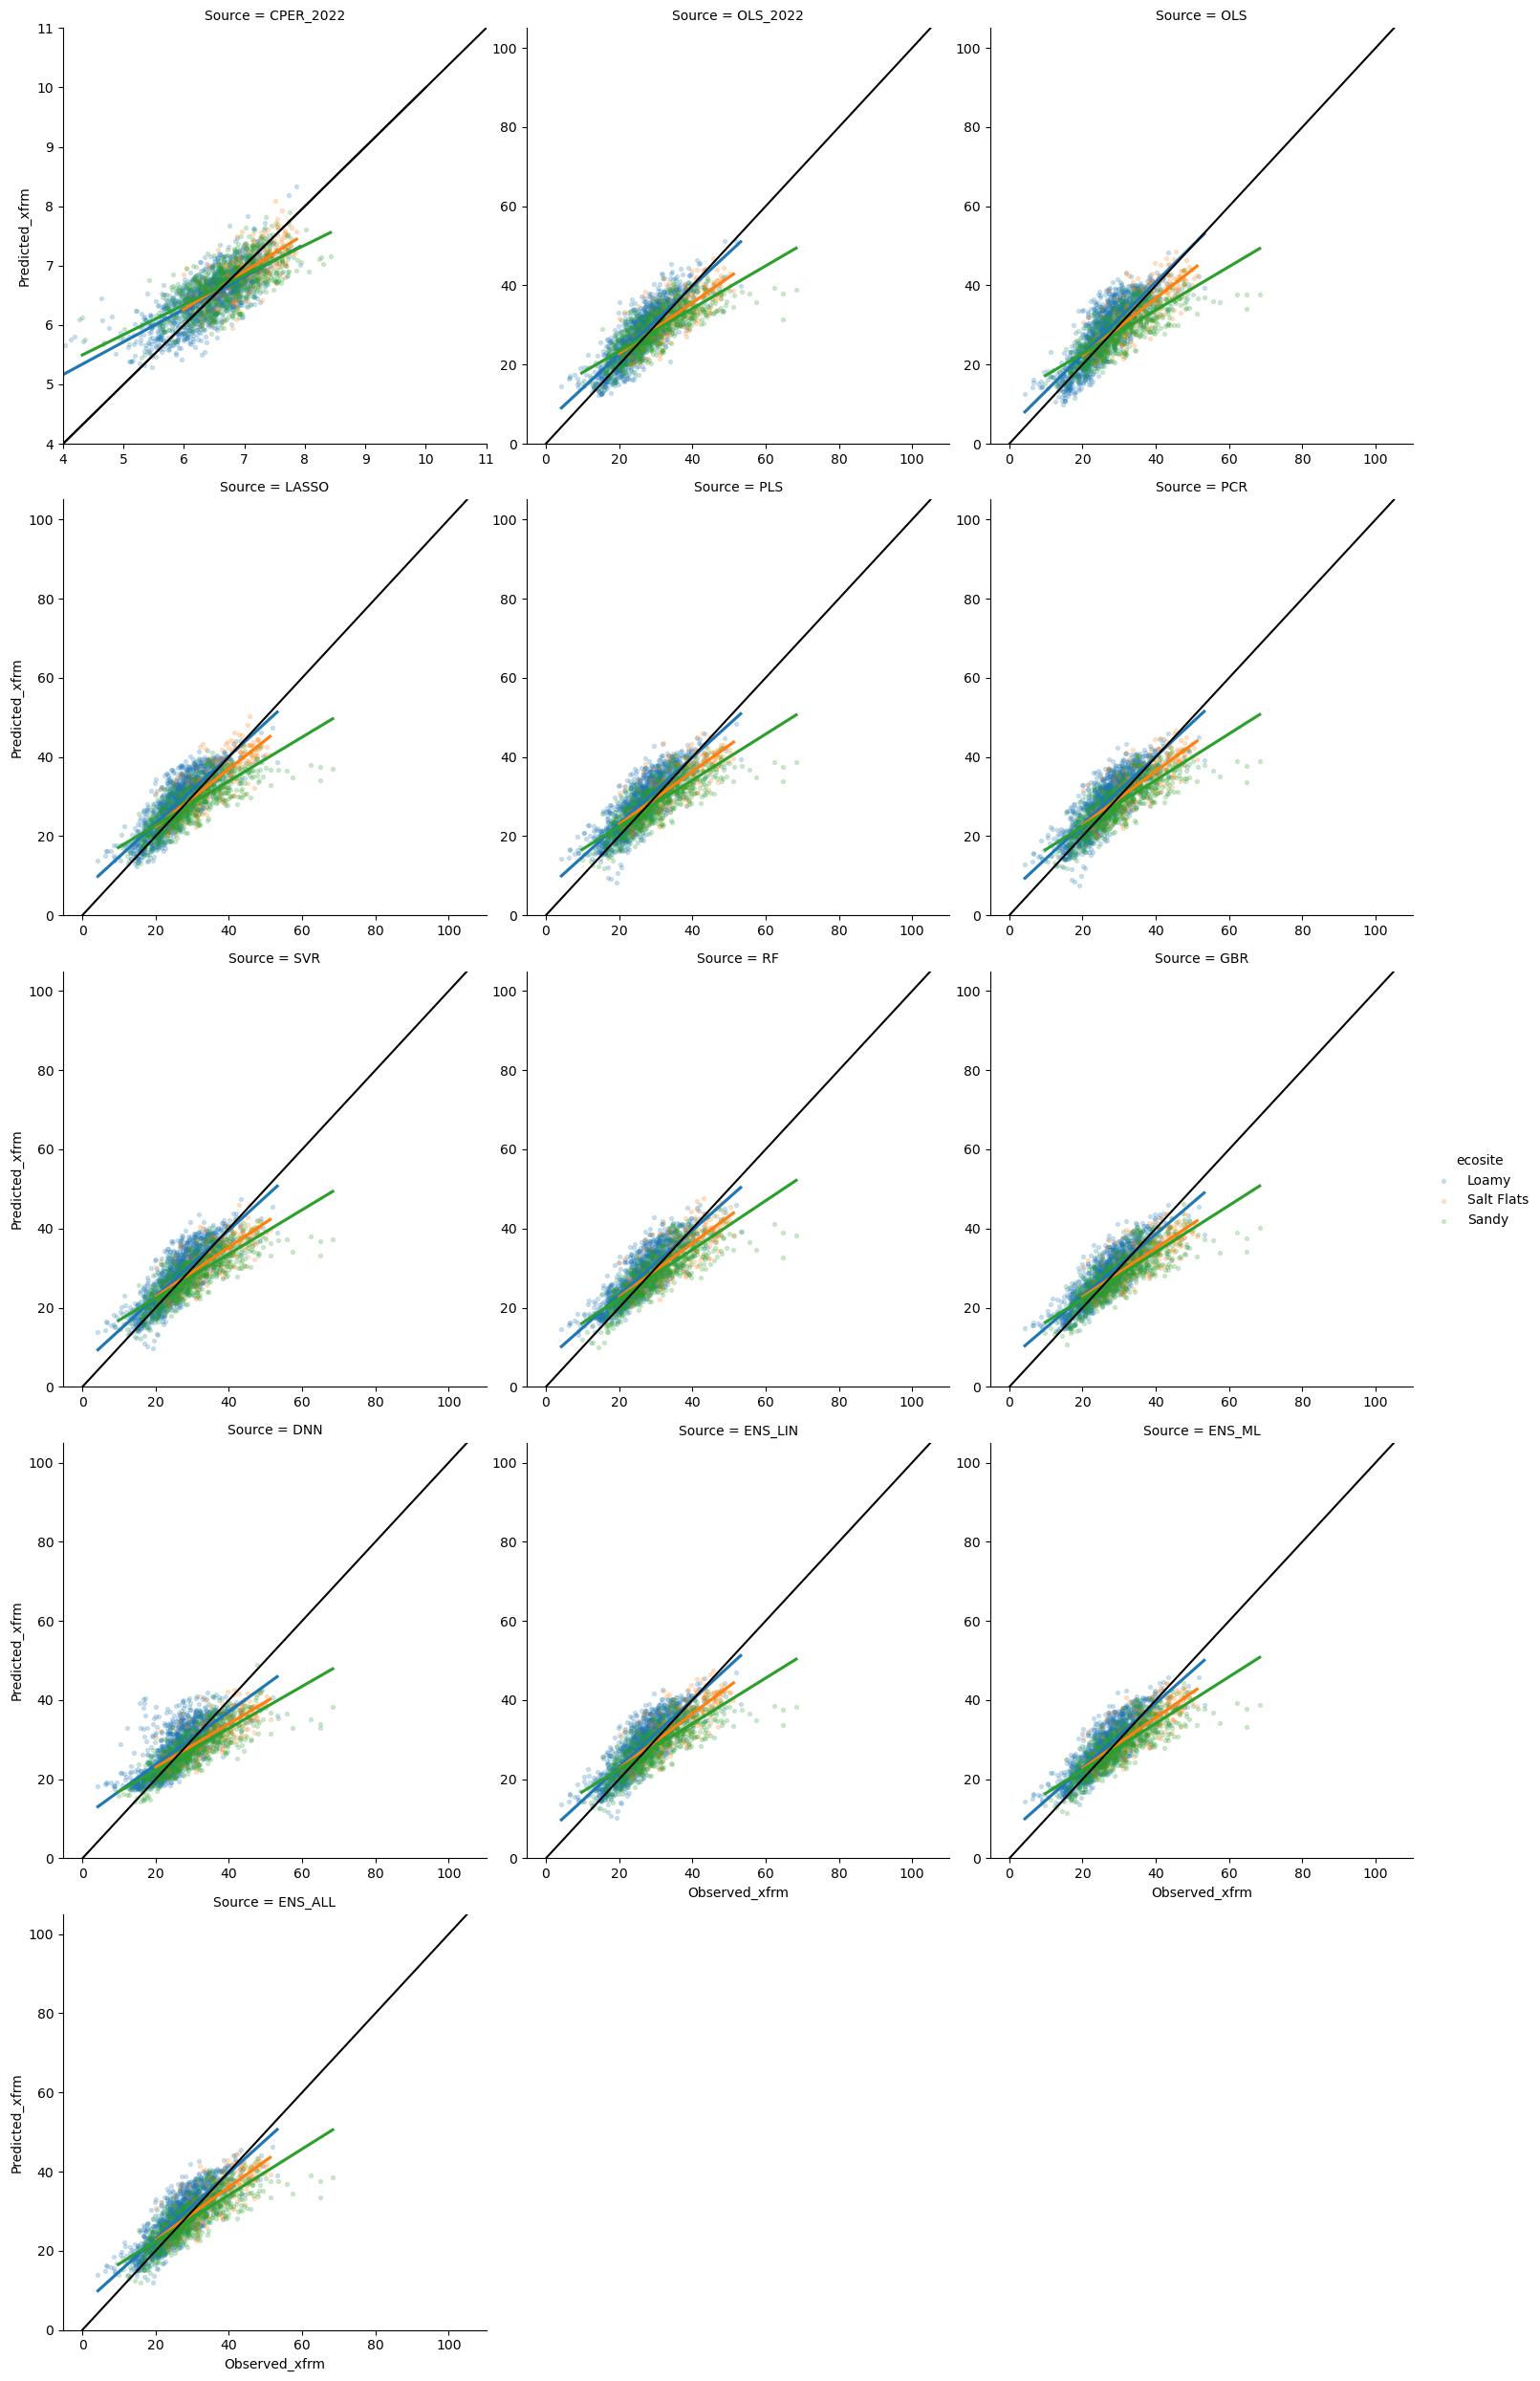

In [96]:
p_plot = sns.lmplot(df_bm_pred.groupby([mod_col, logo_group, 'Plot', date_col], 
                                       observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index(),
               x='Observed_xfrm', y='Predicted_xfrm', col=mod_col, col_wrap=3,
                    facet_kws=dict(sharey=False, sharex=False,),
                    hue=logo_group, ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.2, 'edgecolor': None})
for ax in p_plot.axes:
    ax.set_ylim((0, max_lim_xfrm))
    ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')
p_plot.axes[0].set_ylim((4, 11))
p_plot.axes[0].set_xlim((4, 11))
p_plot.axes[0].plot(np.arange(4, 11), np.arange(4, 11), c='black')
if save_results:
    plt.savefig(os.path.join(outDIR, 
                             'figures/ml_models', 
                             re.sub('tmp.csv', 'results_plot.png', os.path.basename(inPATH))), dpi=100)

In [97]:
p_plot_best = sns.lmplot(df_bm_pred[df_bm_pred[mod_col] == 'PLS'].groupby([logo_group, 'Plot', date_col], 
                                       observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index(),
               x='Observed_xfrm', y='Predicted_xfrm', ci=None, hue=logo_group,
                    scatter_kws={'s': 8, 'alpha': 1, 'edgecolor': None})
for ax in p_plot_best.axes.flatten():
    ax.set_ylim((0, max_lim_xfrm))
    ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')

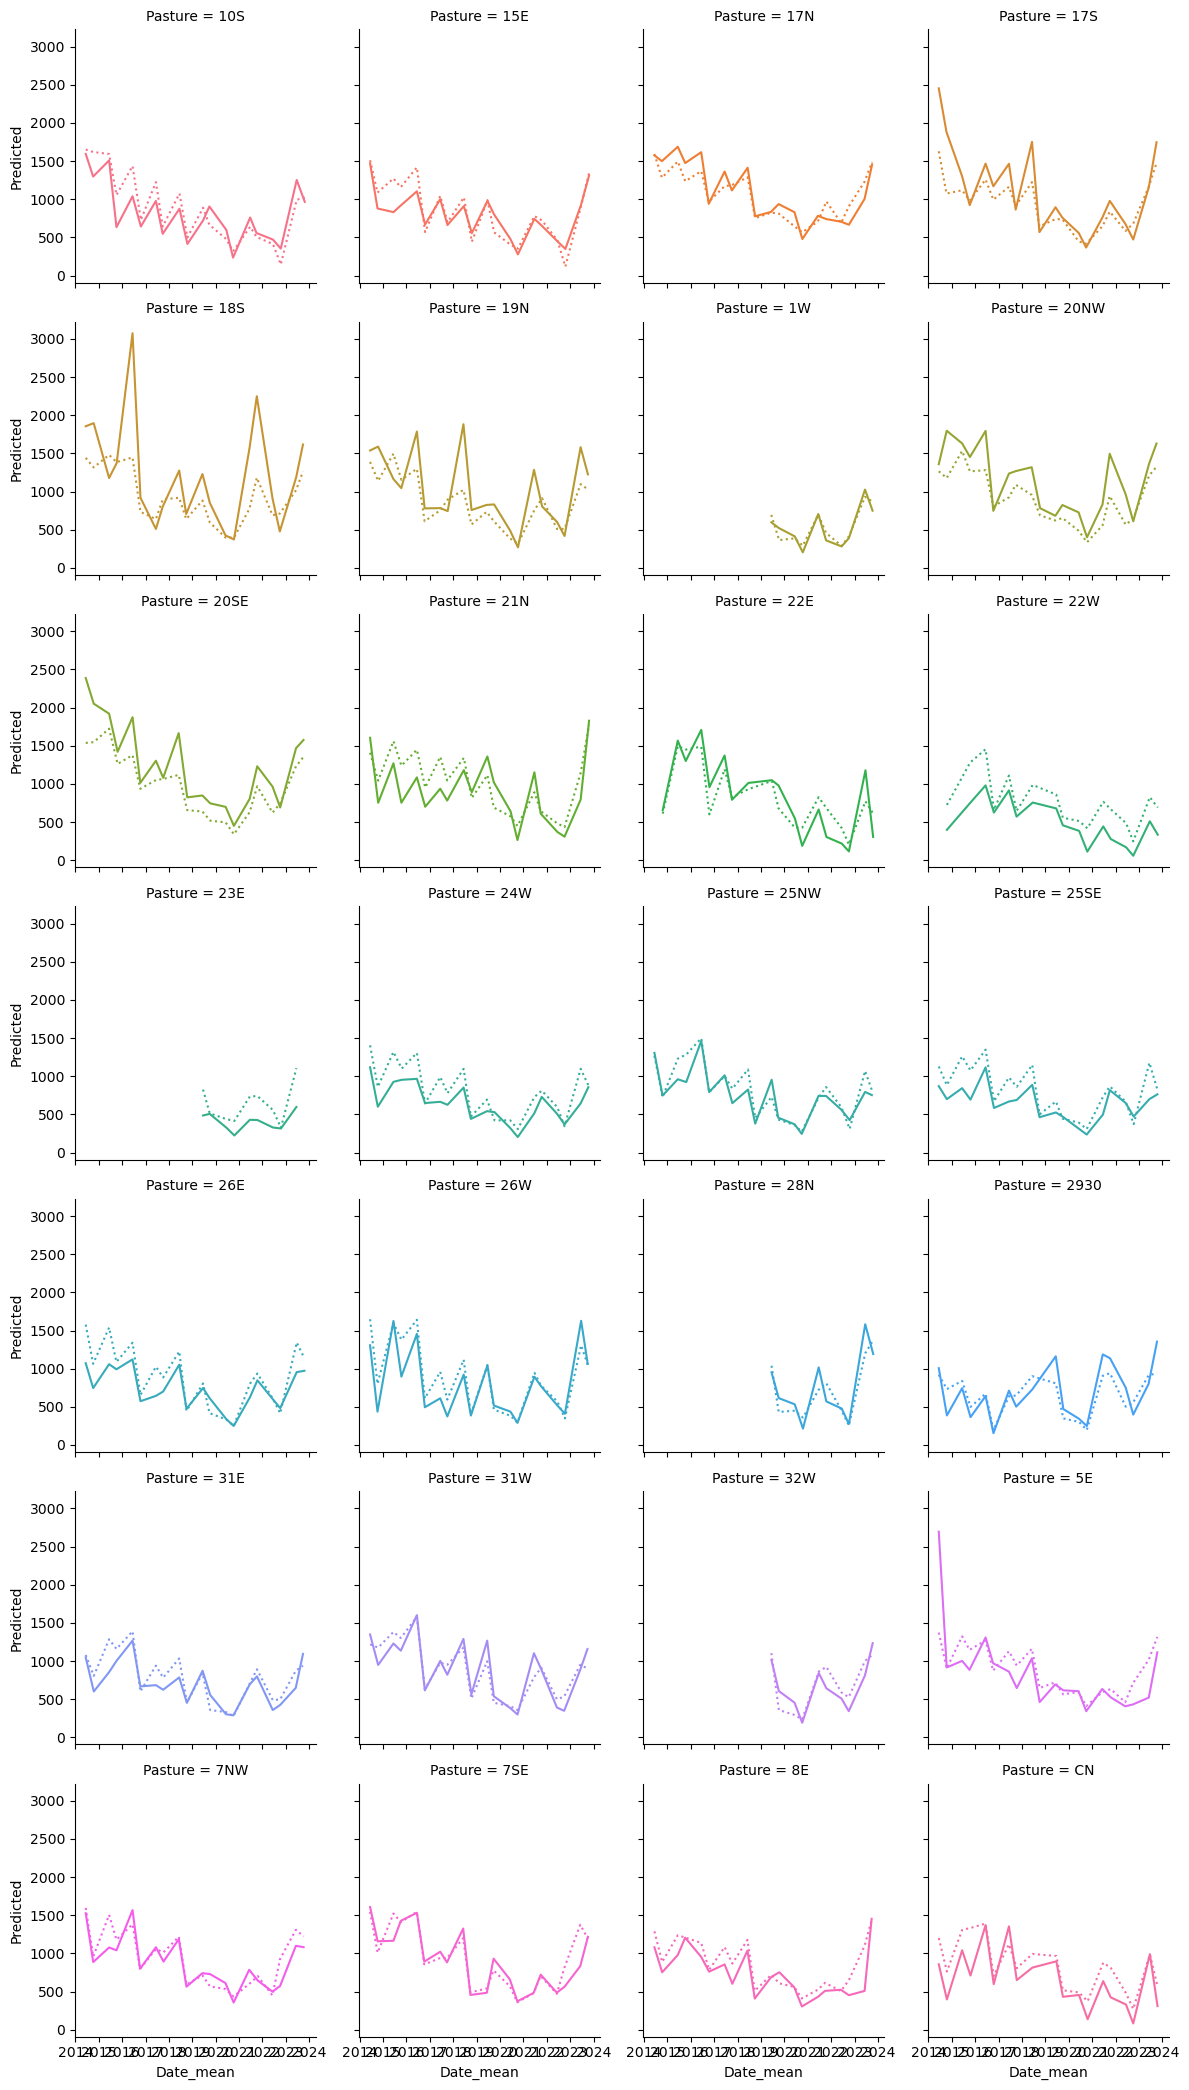

In [98]:
df_bm_pred[date_col] = pd.to_datetime(df_bm_pred[date_col])
df_bm_pred['DOY'] = df_bm_pred[date_col].dt.dayofyear
p_plot_ts_best = sns.FacetGrid(hue=past_col, 
                               data=df_bm_pred[df_bm_pred[mod_col] == 'PLS'].groupby(
                                   [past_col, 'DOY', date_col], 
                                   observed=True)[['Observed', 'Predicted']].mean().reset_index().sort_values([past_col, date_col]),
                               col=past_col, col_wrap=4, sharex=True)
p_plot_ts_best.map(plt.plot, date_col, 'Observed', linestyle='solid')
p_plot_ts_best.map(plt.plot, date_col, 'Predicted', linestyle='dotted')

### Pasture

In [99]:
mae_pasture = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([past_col] + group_cols).apply(lambda x: abs(np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm'])),
                                                      include_groups=False).mean(), 
    include_groups=False).round(2)
bias_pasture = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([past_col] + group_cols).apply(
        lambda x: np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm']),
        include_groups=False).mean(), include_groups=False).round(2)
mae_bt_pasture = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([past_col] + group_cols).apply(
        lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])), 
        include_groups=False).mean(), include_groups=False).round(2)
bias_bt_pasture = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([past_col] + group_cols).apply(
        lambda x: np.mean(x['Predicted']) - np.mean(x['Observed']), 
        include_groups=False).mean(), include_groups=False).round(2)
r2_pasture = df_bm_pred.groupby([mod_col, past_col, logo_group] + group_cols, 
                                observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby([mod_col, logo_group],
                                                                                                                observed=True).apply(
    lambda x: r2_score(x['Observed_xfrm'], x['Predicted_xfrm']), 
    include_groups=False).round(2)
r2_corr_pasture = df_bm_pred.groupby([mod_col, past_col, logo_group] + group_cols,
                                     observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby([mod_col, logo_group],
                                                                                          observed=True).apply(
    lambda x: r_corrcoef(x['Observed_xfrm'], x['Predicted_xfrm']),
    include_groups=False).round(2)

In [100]:
df_smry_pasture = pd.DataFrame({
    'MAE': mae_pasture.unstack(level=0).mean().round(2),
    'MAE_std': mae_pasture.unstack(level=0).std().round(2),
    'Bias': bias_pasture.unstack(level=0).mean().round(2),
    'Bias_std': bias_pasture.unstack(level=0).std().round(2),
    'R^2': r2_pasture.unstack(level=0).mean().round(2),
    'R^2_std': r2_pasture.unstack(level=0).std().round(2),
    'r': r2_corr_pasture.unstack(level=0).mean().round(2),
    'r_std': r2_corr_pasture.unstack(level=0).std().round(2),
    'MAE_bt': mae_bt_pasture.unstack(level=0).mean().round(2),
    'MAE_bt_std': mae_bt_pasture.unstack(level=0).std().round(2),
    'MAE_bt_pct': (mae_bt_pasture / df_bm_pred.groupby([mod_col, past_col, logo_group], 
                                                    observed=True)['Observed'].mean()).unstack(level=0).mean().round(2),
    'MAE_bt_pct_std': (mae_bt_pasture / df_bm_pred.groupby([mod_col, past_col, logo_group], 
                                                    observed=True)['Observed'].mean()).unstack(level=0).std().round(2),
    'Bias_bt': bias_bt_pasture.unstack(level=0).mean().round(2),
    'Bias_bt_std': bias_bt_pasture.unstack(level=0).std().round(2),
})
display(df_smry_pasture)
if save_results:
    df_smry_pasture.to_csv(os.path.join(outDIR,
                                     'tables/ml_models', 
                                     re.sub('tmp.csv', 'results_pasture.csv', os.path.basename(inPATH))))

df_smry_pasture_by_yr = pd.DataFrame({
    'MAE': mae_pasture.round(2),
    'Bias': bias_pasture.round(2),
    'MAE_bt': mae_bt_pasture.round(2),
    'MAE_pct': (mae_bt_pasture / df_bm_pred.groupby([mod_col, logo_group],
                                                    observed=True)['Observed'].mean()).round(2),
    'R^2': r2_pasture.round(2),
    'r': r2_corr_pasture.round(2)
})
#display(df_smry_pasture_by_yr.sort_values('r'))
if save_results:
    df_smry_pasture_by_yr.to_csv(os.path.join(outDIR,
                                     'tables/ml_models', 
                                     re.sub('tmp.csv', 'results_pasture_yrly.csv', os.path.basename(inPATH))))

MAE  MAE_std  Bias  Bias_std   R^2  R^2_std     r  r_std  MAE_bt  \
Source                                                                         
CPER_2022  0.28     0.02 -0.02      0.11  0.48     0.07  0.73   0.03  273.63   
OLS_2022   3.51     0.51 -0.62      2.31  0.61     0.06  0.83   0.03  232.44   
OLS        3.49     0.17 -0.41      2.15  0.62     0.03  0.84   0.03  228.78   
LASSO      3.28     0.14 -0.26      2.26  0.64     0.04  0.86   0.03  214.58   
PLS        3.39     0.23 -0.44      2.30  0.63     0.03  0.85   0.02  223.17   
PCR        3.37     0.20 -0.44      2.25  0.64     0.03  0.85   0.02  221.88   
SVR        3.50     0.57 -0.99      2.47  0.61     0.06  0.85   0.02  234.06   
RF         3.14     0.36 -0.47      2.24  0.67     0.04  0.87   0.02  209.13   
GBR        3.36     0.77 -1.05      2.43  0.63     0.11  0.86   0.03  225.94   
DNN        3.85     0.89 -1.51      2.88  0.50     0.12  0.82   0.02  258.45   
ENS_LIN    3.32     0.17 -0.37      2.27  0.65     0.02  0.85   0.02  218.79   
ENS_ML     3.27     0.55 -0.82      2.38  0.65     0.06  0.87   0.02  219.49   
ENS_ALL    3.28     0.36 -0.59      2.32  0.65     0.02  0.86   0.02  217.69   

           MAE_bt_std  MAE_bt_pct  MAE_bt_pct_std  Bias_bt  Bias_bt_std  
Source                                                                   
CPER_2022       74.60        0.29            0.06   -88.44       100.01  
OLS_2022        65.96        0.24            0.05   -76.82       156.74  
OLS             40.17        0.25            0.06   -56.13       145.42  
LASSO           36.42        0.24            0.06   -50.03       146.09  
PLS             48.58        0.24            0.05   -64.73       152.70  
PCR             45.08        0.24            0.05   -62.80       149.70  
SVR             71.18        0.24            0.05  -100.92       168.25  
RF              54.28        0.22            0.05   -65.39       146.86  
GBR             84.06        0.22            0.05  -106.44       164.22  
DNN             94.52        0.26            0.05  -138.62       193.70  
ENS_LIN         43.05        0.24            0.05   -59.19       149.26  
ENS_ML          69.44        0.22            0.05   -90.92       159.53  
ENS_ALL         55.79        0.23            0.05   -75.05       153.94

In [101]:
p_past = sns.lmplot(df_bm_pred.groupby(list(set([mod_col, logo_group, past_col] + group_cols)),
                                      observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index(),
               x='Observed_xfrm', y='Predicted_xfrm', col=mod_col, col_wrap=3,
                    facet_kws=dict(sharey=False, sharex=False,),
                    hue=logo_group, ci=None,
                    scatter_kws={'s': 8, 'alpha': 1, 'edgecolor': None})
for ax in p_past.axes:
    ax.set_ylim((0, max_lim_xfrm))
    ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')
p_past.axes[0].set_ylim((4, 11))
p_past.axes[0].set_xlim((4, 11))
p_past.axes[0].plot(np.arange(4, 11), np.arange(4, 11), c='black')
if save_results:
    plt.savefig(os.path.join(outDIR, 
                             'figures/ml_models', 
                             re.sub('tmp.csv', 'results_pasture.png', os.path.basename(inPATH))), dpi=100)

## Extra plots (not currently used)

In [46]:
if 'Transect' in df_bm_pred.columns:
    p_trans = sns.lmplot(df_bm_pred, x='Observed', y='Predicted', col='Source', col_wrap=3, hue='Year', ci=None,
                         scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
    for ax in p_trans.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
    if save_results:
        plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_transect_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)
else:
    p_trans=None

In [47]:
p_plot = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Date_mean']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', col_wrap=3,
               hue='Year', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

/local/bgfs/sean.kearney/12409755/ipykernel_1012764/3509725408.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p_plot = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Date_mean']).mean().reset_index(),


TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
p_pasture = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Date_mean']).mean().reset_index(), 
               x='Observed', y='Predicted', col='Source', col_wrap=3, 
               hue='Year', ci=None, 
                       scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_pasture.axes:
    ax.set_ylim((0, 4000))
    ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

In [ ]:
p_plot_seas = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Date_mean', 'Season']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', col_wrap=3,
               hue='Season', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot_seas.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_plot_by_season_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

In [ ]:
p_pasture_seas = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Date_mean', 'Season']).mean().reset_index(), 
               x='Observed', y='Predicted', col='Source', col_wrap=3, 
               hue='Season', ci=None, 
                       scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_pasture_seas.axes:
    ax.set_ylim((0, 4000))
    ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_pasture_by_season_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

## Make variable importance dataframes

In [102]:
df_ols = mod_dict['OLS']['formula_df']

In [103]:
df_ols['features'] = df_ols['formula'].apply(lambda x: [f for f in x.split(' ~ ')[-1].split(' + ') if ':' not in f])

In [104]:
from tqdm import tqdm
"""
Calculated weighted relative variable importance for each variable across model types
"""
# set max vars based on where cross-validated metrics stop improving
max_vars = 3

var_names = list(set(df_ols['features'].sum()))

# Calculate decomposed R^2, relative variable importance (RVI) and AIC weights
df_ols_feats_ptn = pd.DataFrame(columns=['kfold', 'features', 'formula', 'RVI', 'weight'])
for k in df_ols['kfold'].unique():
    print(k)
    df_ols_sub_tmp = df_ols[(df_ols['kfold'] == k) &
    (df_ols['numb_vars'] <= max_vars)].copy()
    min_aic = (df_ols_sub_tmp['AIC']*0.001).min()
    df_ols_sub_tmp['AICw'] = [np.exp(-0.5 * x) for x in (df_ols_sub_tmp['AIC']*0.001 - min_aic)] / \
    np.sum([np.exp(-0.5 * x) for x in (df_ols_sub_tmp['AIC']*0.001 - min_aic)])
    for f in tqdm(var_names):
        df_ols_sub_f = df_ols_sub_tmp[[f in n for n in df_ols_sub_tmp['formula']]]
        if len(df_ols_sub_f) == 0:
            continue
        else:
            for f_form in df_ols_sub_f['formula']:
                f_form_omitted = re.sub(f + ":[^\+]* \+ ", "",
                                        re.sub(" \+ " + f + ":[^\+]*", "",
                                               re.sub(" \+ " + f + ":.+?(?= |$)", "",
                                                      re.sub(" \+(?<=\+)[^\+]*:" + f, "",
                                                             re.sub("\+ " + f + " (?=\+)", "",
                                                                    re.sub("(?<=~ )" + f + " \+ ", "",
                                                                           f_form))))))

                # print(f_form)
                # print(f_form_omitted)
                RVI_tmp = df_ols_sub_tmp['R2_adj'][(df_ols_sub_tmp['formula'] == f_form)].values - \
                          df_ols_sub_tmp['R2_adj'][(df_ols_sub_tmp['formula'] == f_form_omitted)].values
                OVI_tmp = df_ols_sub_tmp['mae_orig_mean'][(df_ols_sub_tmp['formula'] == f_form)].values - \
                          df_ols_sub_tmp['mae_orig_mean'][(df_ols_sub_tmp['formula'] == f_form_omitted)].values
                weight_tmp = df_ols_sub_tmp['AICw'][(df_ols_sub_tmp['formula'] == f_form)].values

                df_ols_feats_tmp = pd.DataFrame(dict(kfold=k,
                                                     features=f,
                                                     formula=f_form,
                                                     RVI=np.mean(RVI_tmp),
                                                     weight=weight_tmp),
                                                index=[0])
                df_ols_feats_ptn = pd.concat([df_ols_feats_ptn,df_ols_feats_tmp])

Loamy


  0%|          | 0/28 [00:00<?, ?it/s]/local/bgfs/sean.kearney/12409755/ipykernel_1012764/2421960830.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_ols_feats_ptn = pd.concat([df_ols_feats_ptn,df_ols_feats_tmp])
100%|██████████| 28/28 [00:05<00:00,  5.07it/s]


Salt Flats


100%|██████████| 28/28 [00:05<00:00,  4.68it/s]


Sandy


100%|██████████| 28/28 [00:06<00:00,  4.49it/s]


In [105]:
def feature_type(f):
    if f in ['RED', 'GREEN', 'BLUE', 'NIR', 'SWIR1', 'SWIR2']:
        return 'Band'
    elif 'BAI' in f:
        return 'BAI'
    else:
        return 'Veg. Index'

# calculate weighted relative variable importance (RVIw)
df_ols_feats_ptn['RVIw'] = df_ols_feats_ptn['RVI'] * df_ols_feats_ptn['weight']

# add input variable group field
df_ols_feats_ptn['group'] = df_ols_feats_ptn['features'].apply(feature_type)

# calculate sorted mean RVIw for each feature after summing across each kfold
df_ols_feats_grp = df_ols_feats_ptn.groupby(['kfold',
                                             'features',
                                             'group'])['RVIw'].sum().reset_index()
df_ols_feats_grp['RVIw_norm'] = df_ols_feats_grp.groupby('kfold')['RVIw'].transform(lambda x: x / x.mean())
df_ols_feats_grp['RVIw_mean'] = df_ols_feats_grp.groupby(['features'])['RVIw'].transform('mean')
df_ols_feats_grp = df_ols_feats_grp.sort_values(['RVIw_mean'], ascending=False).reset_index(drop=True)

In [106]:
df_ols_feats_grp['kfold'] = df_ols_feats_grp['kfold'].astype('str')
if kfold_group == 'Year':
    df_ols_feats_grp['kfold'] = pd.Categorical(df_ols_feats_grp['kfold'], 
                                               [str(x) for x in range(min(df_ols_feats_grp['kfold'].astype(int)),
                                                                      max(df_ols_feats_grp['kfold'].astype(int))+1)])

In [107]:
df_lasso_coefs = mod_dict['LASSO']['variable_df']
df_lasso_coefs['kfold'] = pd.Categorical(df_lasso_coefs['kfold'], categories=df_lasso_coefs['kfold'].sort_values().unique())
df_lasso_coefs['Coef_abs'] = abs(df_lasso_coefs['Coef'])
df_lasso_coefs_ranked = df_lasso_coefs.groupby('Variable', observed=True)['Coef_abs'].mean().sort_values(ascending=False)
df_lasso_coefs['Variable'] = pd.Categorical(df_lasso_coefs['Variable'], categories=df_lasso_coefs_ranked.index.values)
df_lasso_coefs['Coef_norm'] = df_lasso_coefs.groupby('kfold', observed=True)['Coef_abs'].transform(lambda x: x / x.mean())

dfs_lasso = []
for k in df_lasso_coefs['kfold'].unique():
    dfs_lasso_tmp = pd.DataFrame(data={'Variable': df_ols_feats_grp['features'].unique()})
    dfs_lasso_tmp['kfold'] = k
    dfs_lasso.append(dfs_lasso_tmp)
df_lasso_coefs_all = pd.concat(dfs_lasso)
df_lasso_coefs_all['Coef_abs_sum'] = 0.0
for k in df_lasso_coefs_all['kfold'].unique(): 
    for i in df_lasso_coefs_all['Variable']:
        df_lasso_coefs_all.loc[(df_lasso_coefs_all['Variable'] == i) & 
        (df_lasso_coefs_all['kfold'] == k),
        'Coef_abs_sum'] = df_lasso_coefs[df_lasso_coefs['kfold'] == k][[i in x for x in df_lasso_coefs[df_lasso_coefs['kfold'] == k]['Variable']]]['Coef_abs'].sum()
df_lasso_coefs_all['kfold'] = pd.Categorical(df_lasso_coefs_all['kfold'], categories=df_lasso_coefs_all['kfold'].sort_values().unique())
df_lasso_coefs_ranked = df_lasso_coefs_all.groupby('Variable', observed=True)['Coef_abs_sum'].mean().sort_values(ascending=False)
df_lasso_coefs_all['Variable'] = pd.Categorical(df_lasso_coefs_all['Variable'], categories=df_lasso_coefs_ranked.index.values)
df_lasso_coefs_all['Coef_norm'] = df_lasso_coefs_all.groupby('kfold', observed=True)['Coef_abs_sum'].transform(lambda x: x / x.mean()) 

In [108]:
df_pls_coefs = mod_dict['PLS']['variable_df']
df_pls_coefs['kfold'] = pd.Categorical(df_pls_coefs['kfold'], categories=df_pls_coefs['kfold'].sort_values().unique())
df_pls_coefs_ranked = df_pls_coefs.groupby('Variable', observed=True)['VIP'].mean().sort_values(ascending=False)
df_pls_coefs['Variable'] = pd.Categorical(df_pls_coefs['Variable'], categories=df_pls_coefs_ranked.index.values)
df_pls_coefs_top = df_pls_coefs[df_pls_coefs['VIP'] > 1.0].copy()
df_pls_coefs_top['Variable'] = df_pls_coefs_top['Variable'].cat.remove_unused_categories()

In [109]:
df_pcr_coefs = mod_dict['PCR']['variable_df']
df_pcr_coefs['kfold'] = pd.Categorical(df_pcr_coefs['kfold'], categories=df_pcr_coefs['kfold'].sort_values().unique())
pcr_coefs_abs_mean = df_pcr_coefs.groupby(['kfold', 'Variable'], observed=True).apply(lambda x: np.mean(np.abs(x), axis=1),
                                                                                     include_groups=False)
pcr_coefs_abs_mean.name = 'Coef_mean_abs'
df_pcr_coefs_mean = pcr_coefs_abs_mean.reset_index()

df_pcr_coefs_mean['Coef_mean_norm'] = df_pcr_coefs_mean.groupby('kfold', observed=True)['Coef_mean_abs'].transform(lambda x: x / x.mean())
pcr_vars_mean_ranked = df_pcr_coefs_mean.groupby('Variable', observed=True)['Coef_mean_abs'].mean().sort_values(ascending=False)
df_pcr_coefs_mean['Variable'] = pd.Categorical(df_pcr_coefs_mean['Variable'], categories=pcr_vars_mean_ranked.index.values)

df_pcr_coefs_mean_top20 = df_pcr_coefs_mean[df_pcr_coefs_mean['Variable'].isin(pcr_vars_mean_ranked.head(20).index.values)].copy()
df_pcr_coefs_mean_top20['Variable'] = df_pcr_coefs_mean_top20['Variable'].cat.remove_unused_categories()

In [110]:
df_svr_wts = mod_dict['SVR']['variable_df'].copy()
df_svr_wts['kfold'] = pd.Categorical(df_svr_wts['kfold'], categories=df_svr_wts['kfold'].sort_values().unique())
df_svr_wts['SVR_weights_abs'] = df_svr_wts['SVR_weights'].transform(lambda x: abs(x))
df_svr_wts['SVR_weights_norm'] = df_svr_wts.groupby('kfold', observed=True)['SVR_weights_abs'].transform(lambda x: x / x.mean())
df_svr_wts_ranked = df_svr_wts.groupby('Variable', observed=True)['SVR_weights_abs'].mean().sort_values(ascending=False)
df_svr_wts['Variable'] = pd.Categorical(df_svr_wts['Variable'], categories=df_svr_wts_ranked.index.values)

In [111]:
df_rf_mdi = mod_dict['RF']['variable_df'].copy()
df_rf_mdi['kfold'] = pd.Categorical(df_rf_mdi['kfold'], categories=df_rf_mdi['kfold'].sort_values().unique())
df_rf_mdi['MDI_norm'] = df_rf_mdi.groupby('kfold', observed=True)['MDI'].transform(lambda x: x / x.mean())
df_rf_mdi_ranked = df_rf_mdi.groupby('Variable', observed=True)['MDI_norm'].mean().sort_values(ascending=False)
df_rf_mdi['Variable'] = pd.Categorical(df_rf_mdi['Variable'], categories=df_rf_mdi_ranked.index.values)

In [112]:
df_gbr_mdi = mod_dict['GBR']['variable_df'].copy()
df_gbr_mdi['kfold'] = pd.Categorical(df_gbr_mdi['kfold'], categories=df_gbr_mdi['kfold'].sort_values().unique())
df_gbr_mdi['MDI_norm'] = df_gbr_mdi.groupby('kfold', observed=True)['MDI'].transform(lambda x: x / x.mean())
df_gbr_mdi_ranked = df_gbr_mdi.groupby('Variable', observed=True)['MDI_norm'].mean().sort_values(ascending=False)
df_gbr_mdi['Variable'] = pd.Categorical(df_gbr_mdi['Variable'], categories=df_gbr_mdi_ranked.index.values)

In [113]:
df_ols_feats_grp['Model'] = 'OLS'
df_ols_feats_grp['VI'] = df_ols_feats_grp['RVIw_norm']
df_ols_feats_grp['Variable'] = df_ols_feats_grp['features']

df_lasso_coefs_all['Model'] = 'LASSO'
df_lasso_coefs_all['VI'] = df_lasso_coefs_all['Coef_norm']

df_pls_coefs['Model'] = 'PLS'
df_pls_coefs['VI'] = df_pls_coefs['VIP']

df_pcr_coefs_mean['Model'] = 'PCR'
df_pcr_coefs_mean['VI'] = df_pcr_coefs_mean['Coef_mean_norm']

df_svr_wts['Model'] = 'SVR'
df_svr_wts['VI'] = df_svr_wts['SVR_weights_norm']

df_rf_mdi['Model'] = 'RF'
df_rf_mdi['VI'] = df_rf_mdi['MDI_norm']

df_gbr_mdi['Model'] = 'GBR'
df_gbr_mdi['VI'] = df_gbr_mdi['MDI_norm']

vi_cols_list = ['Model','kfold', 'Variable', 'VI']

df_vi_all = pd.concat([df_lasso_coefs_all[vi_cols_list],
                       df_pls_coefs[vi_cols_list],
                       df_pcr_coefs_mean[vi_cols_list],
                       df_svr_wts[vi_cols_list],
                       df_rf_mdi[vi_cols_list],
                       df_gbr_mdi[vi_cols_list]])
df_vi_all = df_vi_all.reset_index(drop=True)

## Variable importance plots

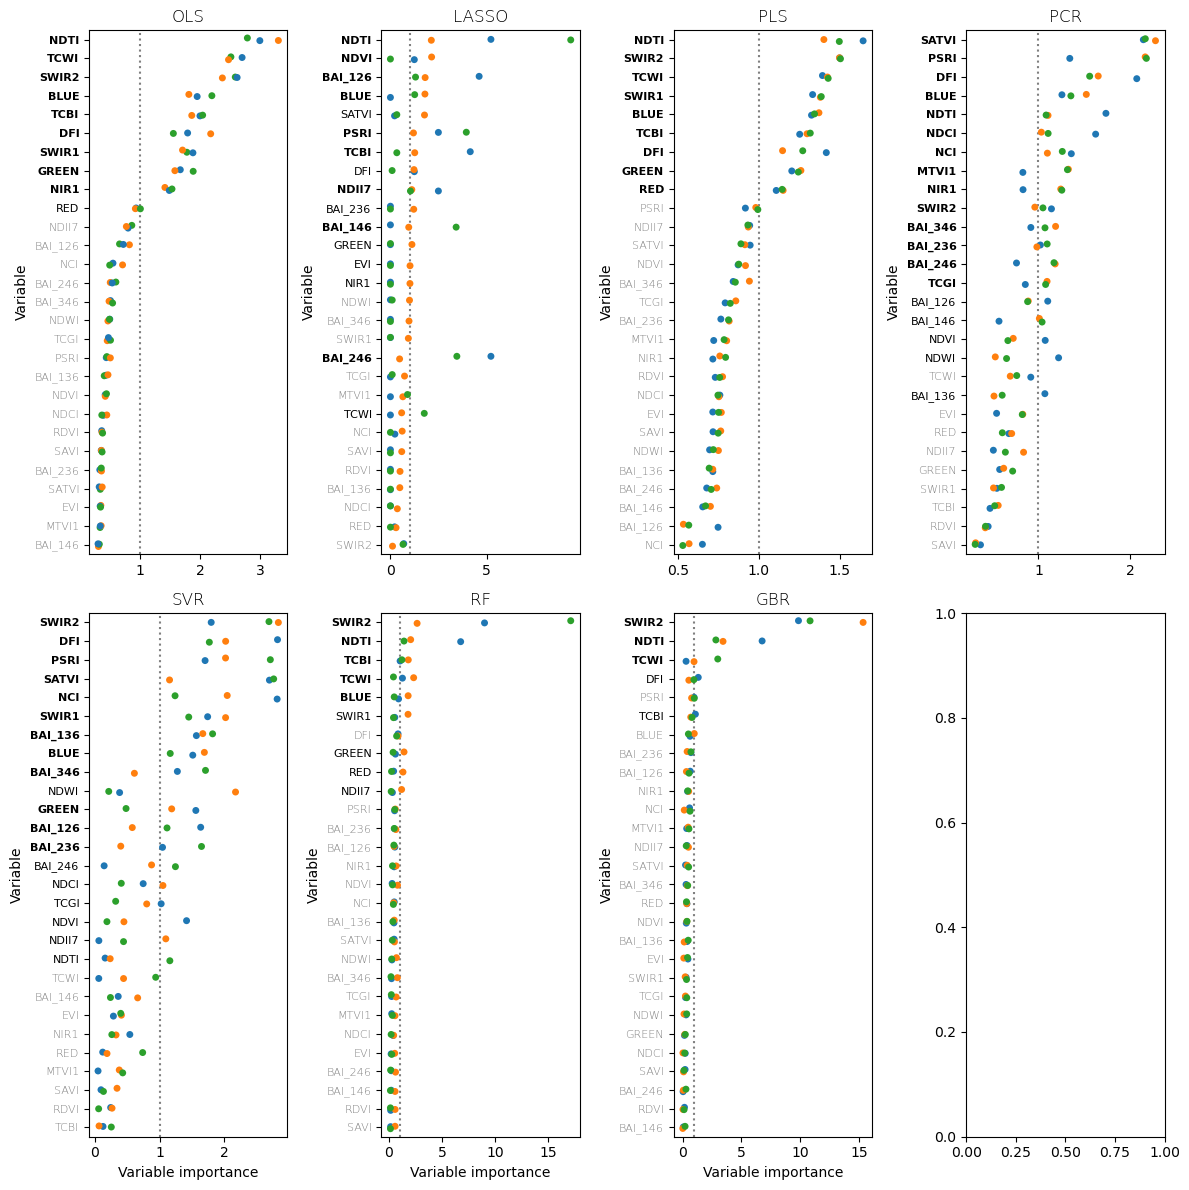

In [114]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(12, 12), 
                        sharex=False, sharey=False)
for idx, df_tmp in enumerate([df_ols_feats_grp,
                              df_lasso_coefs_all,
                              df_pls_coefs,
                              df_pcr_coefs_mean,
                              df_svr_wts,
                              df_rf_mdi,
                              df_gbr_mdi]):
    top_vars = [x for x in df_tmp['Variable'].unique() if df_tmp[df_tmp['Variable'] == x]['VI'].mean() >= 1.0]
    bottom_vars = [x for x in df_tmp['Variable'].unique() if np.all(df_tmp[df_tmp['Variable'] == x]['VI'] < 1.0)]
    sns.stripplot(y='Variable', x='VI', data=df_tmp,
                  hue='kfold', orient='h',
                  ax=axs.flatten()[idx], legend=False)
    for ytick in axs.flatten()[idx].get_yticklabels():
        if ytick.get_text() in top_vars:
            ytick.set_fontweight(800)
        elif ytick.get_text() in bottom_vars:
            ytick.set_fontweight(100)
            ytick.set_color('grey')
    axs.flatten()[idx].yaxis.set_tick_params(labelsize=8)
    axs.flatten()[idx].axvline(x=1.0, linestyle='dotted', color='grey')
    axs.flatten()[idx].set_title(df_tmp['Model'].unique()[0], fontweight=10)
    if idx > 3:
        axs.flatten()[idx].set_xlabel('Variable importance')
    else:
        axs.flatten()[idx].set_xlabel(None)
plt.tight_layout()
if save_results:
    plt.savefig(os.path.join(outDIR, 
                             'figures/ml_models', 
                             re.sub('tmp.csv', 'vi_all.png', os.path.basename(inPATH))), dpi=100)

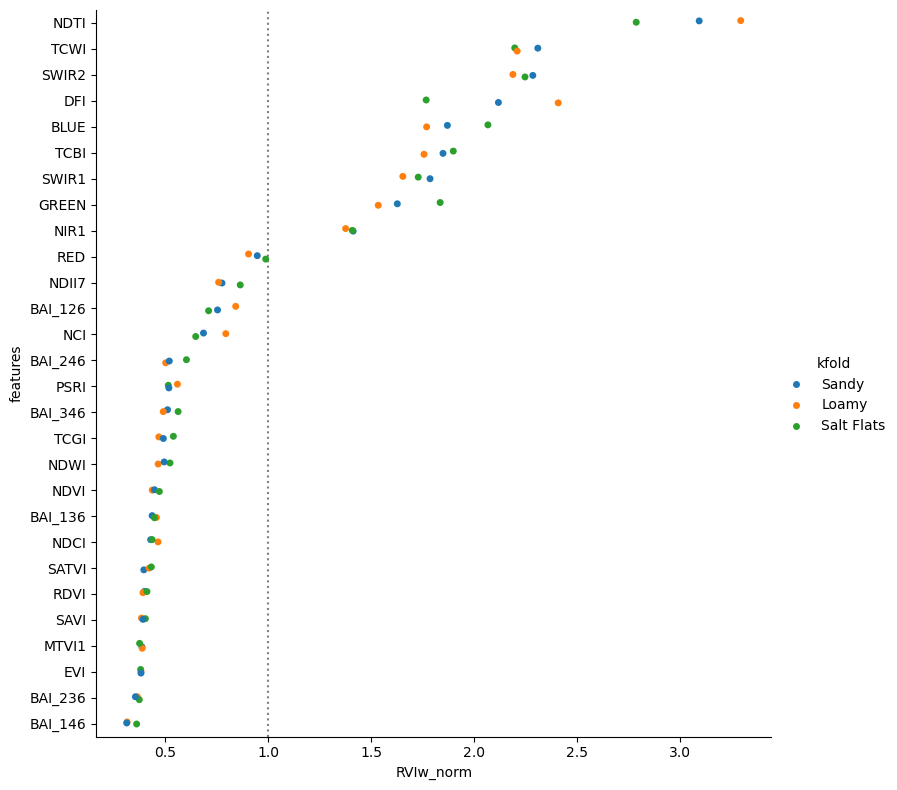

In [86]:
p = sns.catplot(y='features', x='RVIw_norm', hue='kfold',# hue_order=['Band', 'Veg. Index', 'BAI'],
                orient='h',# palette=sns.color_palette()[6:-1],
                data=df_ols_feats_grp,
                height=8, aspect=1.0)
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')
#if save_results:
#    plt.savefig(os.path.join(outDIR, 'figs/varimp/', re.sub('tmp.csv', 'varimp_ols.png', os.path.basename(inPATH))), dpi=100)

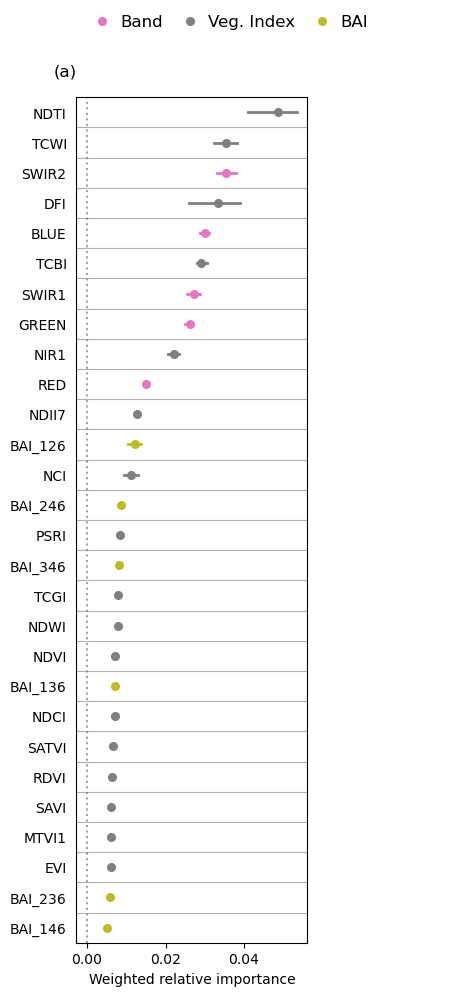

In [87]:
"""
Figure 2: Plot variable importance calculated from all model subsets
"""
font_sml = 10
font_med=12
fig = plt.figure(figsize=(6, 10))
ax1 = fig.add_subplot(1, 2, 1)
pplot1 = sns.pointplot(y='features', x='RVIw', hue='group', hue_order=['Band', 'Veg. Index', 'BAI'],
                       orient='h', dodge=False, ax=ax1, linestyles='None', linewidth=2.0,
                       palette=sns.color_palette()[6:-1],
                       err_kws=dict(linewidth=2.0),
                       data=df_ols_feats_grp)
ax1.set_ylabel('')
ax1.set_xlabel('Weighted relative importance', fontsize=font_sml)
ax1.get_legend().remove()
#ax1.set_xlim((-0.10, 0.50))
ax1.set_yticks(np.arange(0.5, len(df_ols_feats_grp['features'].unique()) - 1, 1), minor=True)
ax1.grid(which='minor', axis='y')
for tic in ax1.yaxis.get_major_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
for tic in ax1.yaxis.get_minor_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
ax1.axvline(x=0, color='grey', alpha=0.75, linestyle='dotted')
ax1.tick_params(axis='x', which='major', labelsize=font_sml)
ax1.tick_params(axis='y', which='major', labelsize=font_sml)
ax1.text(x=-0.1, y=1.025, s='(a)', transform=ax1.transAxes, size=font_med)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), fontsize=font_med,
           columnspacing=0.6, handletextpad=0.1, frameon=False)
plt.tight_layout(w_pad=3.0, rect=(0, 0, 1, 0.95))
if save_results:
    plt.savefig(outDIR_figs + mod_dir_dict[mod_type] + mod_type + '_variable_importance.png', dpi=600,
                bbox_inches='tight', pad_inches=0.2)
    plt.close()

In [ ]:
p = sns.catplot(df_lasso_coefs_all, x='Coef_norm', y='Variable', hue='kfold', height=8, aspect=1.0, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')
#for ax in p.axes.flatten():
#    ax.tick_params(axis='x', rotation=90)

In [ ]:
p = sns.catplot(df_pls_coefs, x='VIP', y='Variable',  hue='kfold', height=8, aspect=1.0, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')

In [ ]:
p = sns.catplot(df_pcr_coefs_mean,
                x='Coef_mean_norm', y='Variable',  hue='kfold', height=6, aspect=1, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')

In [ ]:
p = sns.catplot(df_svr_wts,
                x='SVR_weights_norm', y='Variable',  hue='kfold', height=6, aspect=1, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')
if save_results:
    plt.savefig(os.path.join(outDIR, 'figs/varimp/', re.sub('tmp.csv', 'varimp_svr.png', os.path.basename(inPATH))), dpi=100)

In [94]:
df_svr_wts.groupby('Variable', observed=True)['SVR_weights_norm'].mean()

Variable
SWIR2      3.248787
SWIR1      2.497594
BAI_136    1.827635
NCI        1.629908
NDVI       1.508274
DFI        1.335951
NDWI       1.319505
BAI_346    1.346744
GREEN      1.211063
BLUE       1.172355
PSRI       1.150184
NDCI       1.038067
BAI_126    1.055384
SATVI      0.929783
BAI_236    0.834357
NDTI       0.819090
TCGI       0.726233
BAI_246    0.652782
BAI_146    0.590613
EVI        0.525799
NDII7      0.511270
TCWI       0.523419
RED        0.451092
RDVI       0.442271
SAVI       0.302825
MTVI1      0.130662
NIR1       0.113749
TCBI       0.104606
Name: SVR_weights_norm, dtype: float64

In [ ]:
p = sns.catplot(df_rf_mdi,
                x='MDI_norm', y='Variable',  hue='kfold', height=6, aspect=1, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')
if save_results:
    plt.savefig(os.path.join(outDIR, 'figs/varimp/', re.sub('tmp.csv', 'varimp_rf.png', os.path.basename(inPATH))), dpi=100)

In [ ]:
p = sns.catplot(df_gbr_mdi,
                x='MDI_norm', y='Variable',  hue='kfold', height=6, aspect=1, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')
if save_results:
    plt.savefig(os.path.join(outDIR, 'figs/varimp/', re.sub('tmp.csv', 'varimp_gbr.png', os.path.basename(inPATH))), dpi=100)

## Make parameter tuning dataframes

In [38]:
param_dfs = {}
for k in mod_dict:
    if 'tune_results' in mod_dict[k].keys():
        for idx, kfold in enumerate(mod_dict[k]['tune_results']):
            if idx == 0:
                param_names = list(np.unique([list(x.keys()) for x in mod_dict[k]['tune_results'][kfold]['params']]))
                #param_dfs[k] = pd.DataFrame(columns=['Model', 'kfold', 'Best', 'MAE'] + param_names)
            df_tmp = pd.DataFrame({'Model': k,
                                   'kfold': str(kfold),
                                   'Best': 0,
                                   'MAE': mod_dict[k]['tune_results'][kfold]['mean_test_MAE'],
                                   #'R2': mod_dict[k]['tune_results'][kfold]['mean_test_R2'],
                                   #'R2_train': mod_dict[k]['tune_results'][kfold]['mean_train_R2']
                                  })
            for p in param_names:
                df_tmp[p] = mod_dict[k]['tune_results'][kfold]['param_' + p].data
            idx_best = mod_dict[k]['tune_results'][kfold]['rank_test_MAE'].argmin()
            df_tmp.loc[idx_best, 'Best'] = 1
            if idx == 0:
                param_dfs[k] = df_tmp
            else:
                param_dfs[k] = pd.concat([param_dfs[k], df_tmp.dropna(how='all', axis=0)])
        if k in param_dfs.keys():
            param_dfs[k] = param_dfs[k].reset_index(drop=True)

## Plot parameter tuning

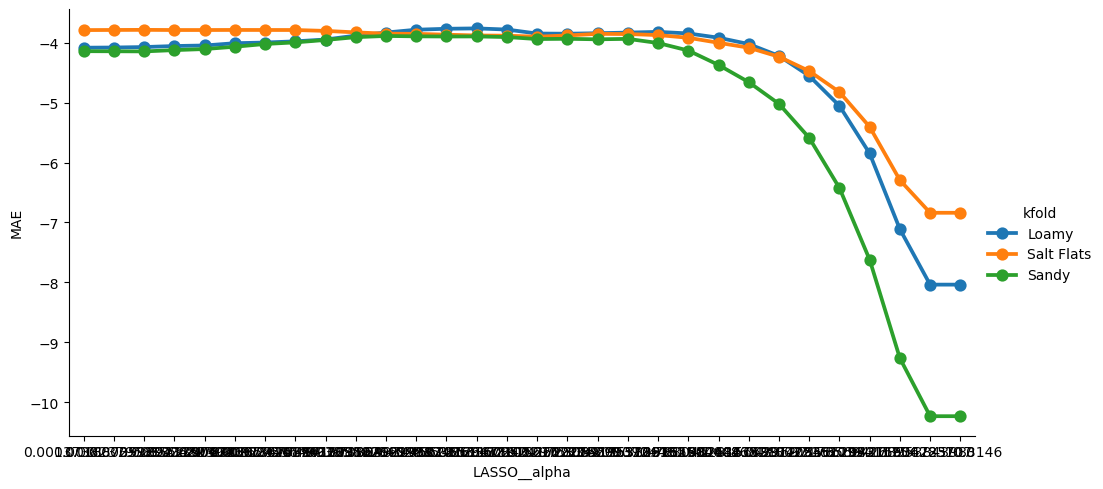

In [101]:
sns.catplot(x='LASSO__alpha', y='MAE', data=param_dfs['LASSO'], hue='kfold', kind='point', aspect=2)

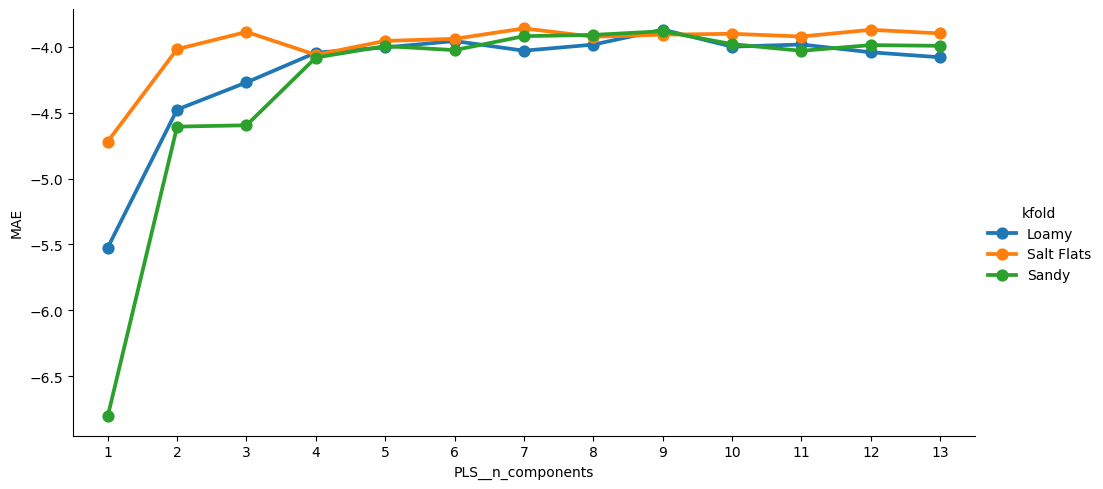

In [102]:
sns.catplot(x='PLS__n_components', y='MAE', data=param_dfs['PLS'], hue='kfold', kind='point', aspect=2)

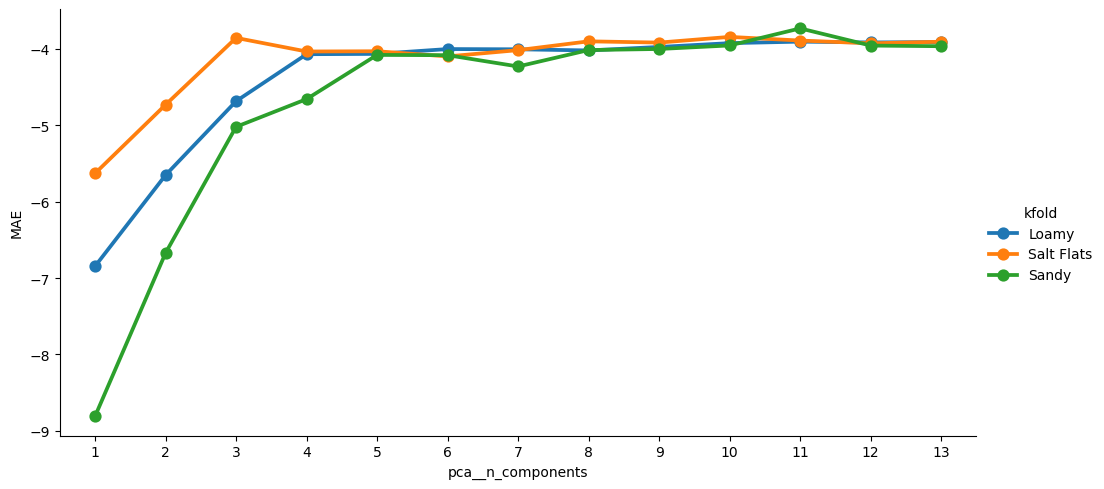

In [103]:
sns.catplot(x='pca__n_components', y='MAE', data=param_dfs['PCR'], hue='kfold', kind='point', aspect=2)

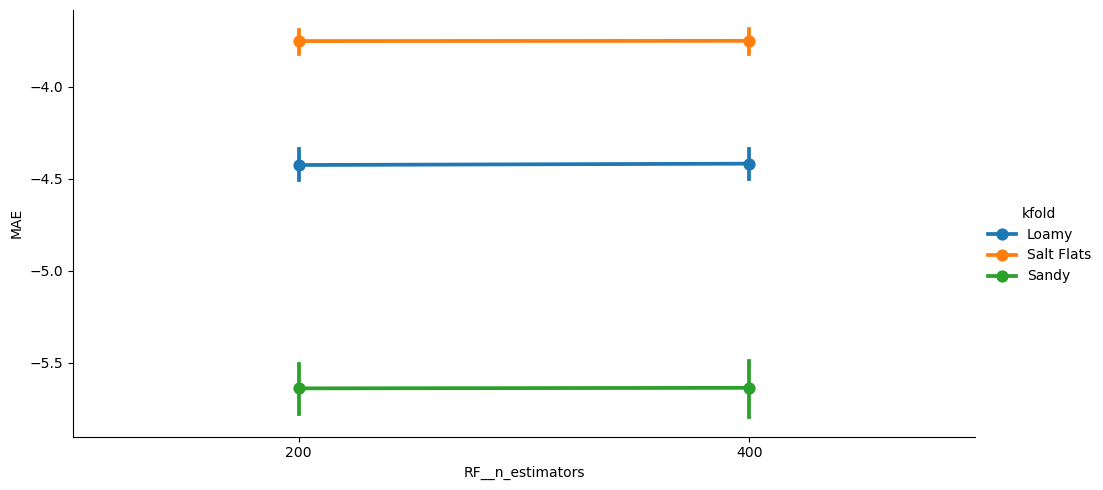

In [104]:
sns.catplot(x='RF__n_estimators', y='MAE', data=param_dfs['RF'], hue='kfold', kind='point', aspect=2)

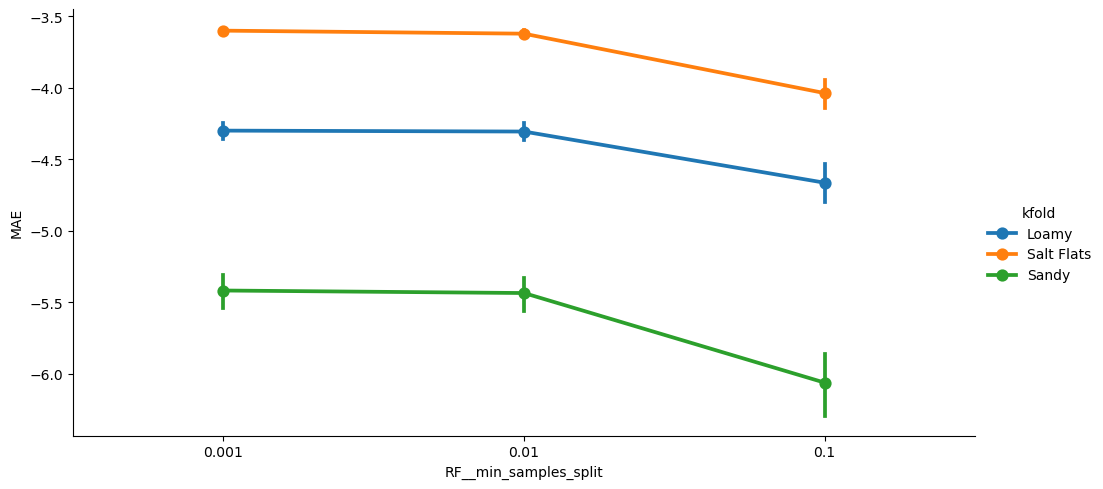

In [105]:
sns.catplot(x='RF__min_samples_split', y='MAE', data=param_dfs['RF'], hue='kfold', kind='point', aspect=2)

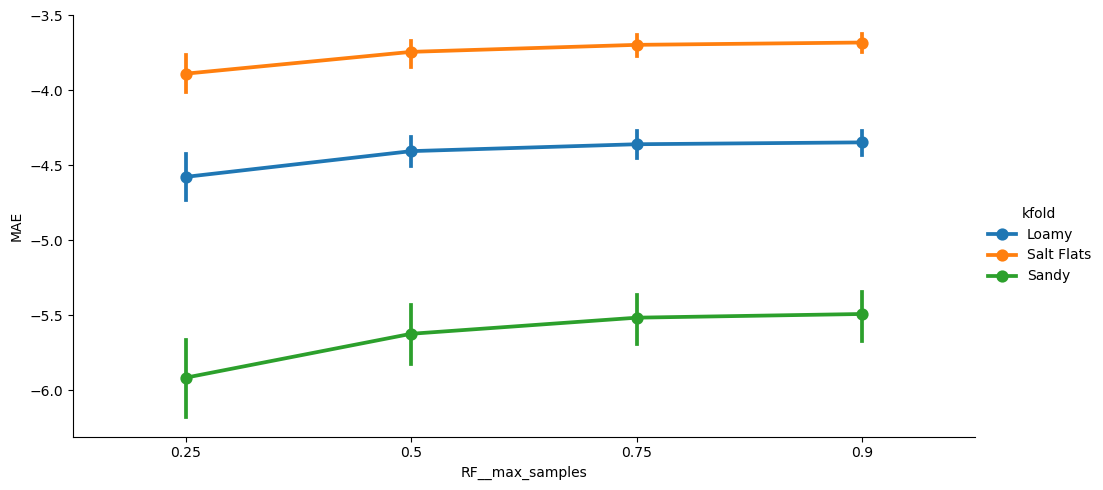

In [106]:
sns.catplot(x='RF__max_samples', y='MAE', data=param_dfs['RF'], hue='kfold', kind='point', aspect=2)

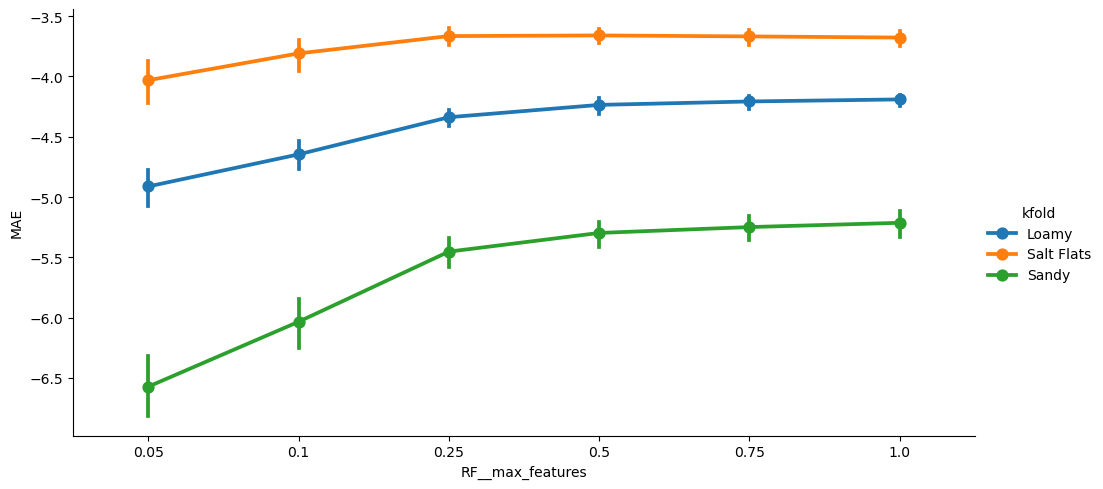

In [107]:
sns.catplot(x='RF__max_features', y='MAE', data=param_dfs['RF'], hue='kfold', kind='point', aspect=2)

In [108]:
sns.catplot(x='SVR__C', y='MAE', data=param_dfs['SVR'], hue='kfold', kind='point', aspect=2)

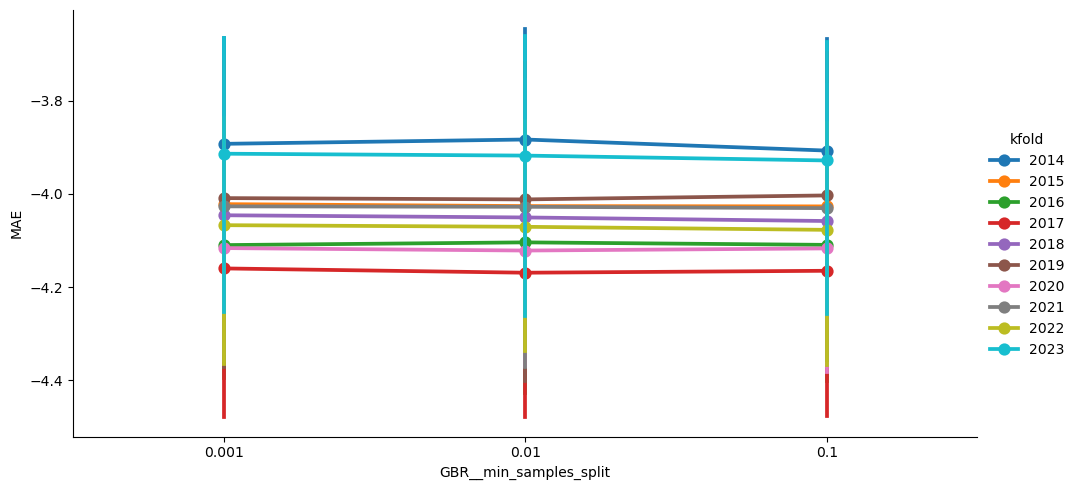

In [114]:
sns.catplot(x='GBR__min_samples_split', y='MAE', data=param_dfs['GBR'], hue='kfold', kind='point', aspect=2)

In [115]:
sns.catplot(x='GBR__learning_rate', y='MAE', data=param_dfs['GBR'], hue='kfold', kind='point', aspect=2)

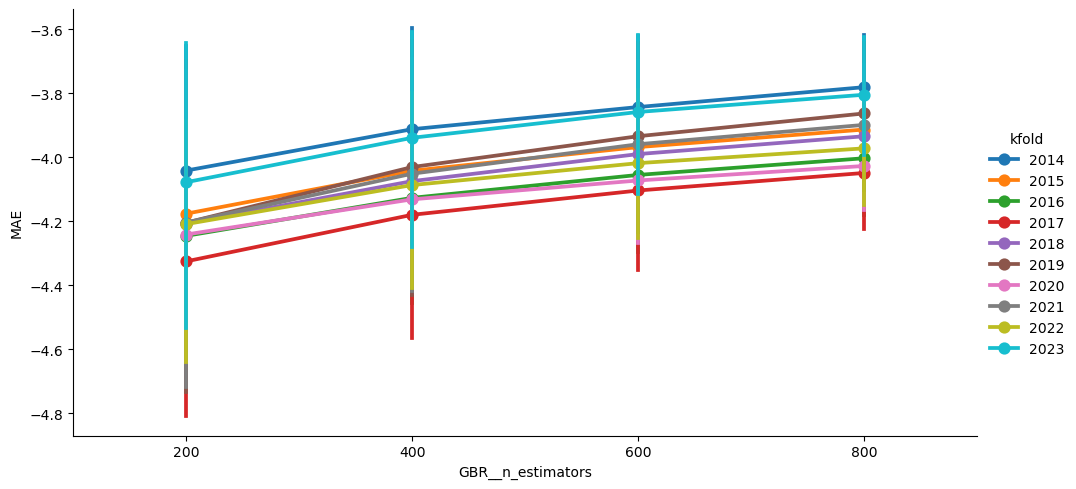

In [116]:
sns.catplot(x='GBR__n_estimators', y='MAE', data=param_dfs['GBR'], hue='kfold', kind='point', aspect=2)

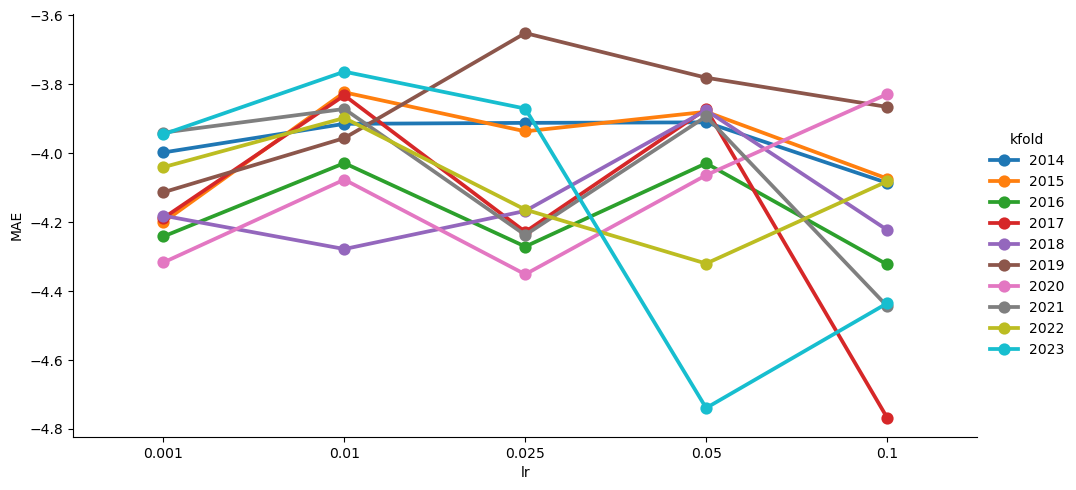

In [118]:
sns.catplot(x='lr', y='MAE', data=param_dfs['DNN'], hue='kfold', kind='point', aspect=2)